In [2]:
import numpy as np
import pandas as pd
import sys
import gc
import joblib
import pathlib
import json
import glob
from tqdm.notebook import tqdm

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

import plotly.graph_objects as go

In [3]:
df = pd.read_csv("/Users/sandeep/Workspace/APEX/RecoveryStocksArbitrage/Yash_Recovery_Stocks.csv")
df = df.drop(index = 72)
df

Ticker                          Name  Total Return:M-6  \
0   BASE US Equity                 COUCHBASE INC            -30.70   
1    SPT US Equity   SPROUT SOCIAL INC - CLASS A            -30.92   
2   ASAN US Equity              ASANA INC - CL A            -31.53   
3     XM US Equity  QUALTRICS INTERNATIONAL-CL A            -32.03   
4   RPAY US Equity           REPAY HOLDINGS CORP            -32.19   
..             ...                           ...               ...   
67   API US Equity                 AGORA INC-ADR            -70.62   
68    KC US Equity   KINGSOFT CLOUD HOLDINGS-ADR            -74.03   
69  STNE US Equity                 STONECO LTD-A            -74.32   
70  TUYA US Equity                      TUYA INC            -75.15   
71  OCFT US Equity   ONECONNECT FINANCIAL TECHNO            -78.05   

    Rev - 1 Yr Gr:Q    Market Cap  Market Cap.1  Price:D-1    P/E  
0             20.16  9.150515e+08  9.150515e+08      20.99    NaN  
1             45.82  3.414239e+09  3.414239e+09      63.22    NaN  
2             70.34  8.948612e+09  8.948612e+09      48.00    NaN  
3             47.98  1.543719e+10  1.543719e+10      27.06    NaN  
4             62.42  1.552755e+09  1.552755e+09      17.15    NaN  
..              ...           ...           ...        ...    ...  
67            46.00  1.083391e+09  1.083391e+09       9.35    NaN  
68            39.62  1.781101e+09  1.781101e+09       7.37    NaN  
69            57.30  4.528934e+09  4.528934e+09      14.66  19.15  
70            44.85  2.783783e+09  2.783783e+09       4.96    NaN  
71            20.78  6.941885e+08  6.941885e+08       1.78    NaN  

[72 rows x 8 columns]

In [4]:
df['Ticker'] = df['Ticker'].replace("", "US Equity")
df = df.replace(to_replace=r' US Equity', value='', regex=True)
df

Ticker                          Name  Total Return:M-6  Rev - 1 Yr Gr:Q  \
0    BASE                 COUCHBASE INC            -30.70            20.16   
1     SPT   SPROUT SOCIAL INC - CLASS A            -30.92            45.82   
2    ASAN              ASANA INC - CL A            -31.53            70.34   
3      XM  QUALTRICS INTERNATIONAL-CL A            -32.03            47.98   
4    RPAY           REPAY HOLDINGS CORP            -32.19            62.42   
..    ...                           ...               ...              ...   
67    API                 AGORA INC-ADR            -70.62            46.00   
68     KC   KINGSOFT CLOUD HOLDINGS-ADR            -74.03            39.62   
69   STNE                 STONECO LTD-A            -74.32            57.30   
70   TUYA                      TUYA INC            -75.15            44.85   
71   OCFT   ONECONNECT FINANCIAL TECHNO            -78.05            20.78   

      Market Cap  Market Cap.1  Price:D-1    P/E  
0   9.150515e+08  9.150515e+08      20.99    NaN  
1   3.414239e+09  3.414239e+09      63.22    NaN  
2   8.948612e+09  8.948612e+09      48.00    NaN  
3   1.543719e+10  1.543719e+10      27.06    NaN  
4   1.552755e+09  1.552755e+09      17.15    NaN  
..           ...           ...        ...    ...  
67  1.083391e+09  1.083391e+09       9.35    NaN  
68  1.781101e+09  1.781101e+09       7.37    NaN  
69  4.528934e+09  4.528934e+09      14.66  19.15  
70  2.783783e+09  2.783783e+09       4.96    NaN  
71  6.941885e+08  6.941885e+08       1.78    NaN  

[72 rows x 8 columns]

In [5]:
import yfinance as yf

# Data gathering
historical_data = dict()

# map ticker labels to their corresponding 3mo historical data
for ticker in df['Ticker']:
    ticker = ticker.replace(" ","")
    #Lets look at the last 3m of data
    data = yf.Ticker(ticker).history(start='2021-11-01', end='2022-01-29', interval="1d")
    # Add day of the week so we can start to see weekly patterns
    data = data.reset_index(0)
    data['Dayofweek'] = pd.to_datetime(data['Date']).dt.dayofweek
    data = data.drop(columns=['High','Low','Dividends', 'Stock Splits'])
    data['Intraday'] = data['Close'] / data['Open']
    data = data.reindex(columns = ['Date', 'Dayofweek', 'Open', 'Close', 'Volume', 'Intraday'])
    historical_data[ticker] = data


In [6]:
# Here are some of the algorithms we will use to backtest potential trading strategies. 
def backtest_in_dollars(df, day):
    # We will start with 1000 usd.
    # This backtest will test buying shares at market open and selling at market close on certain days of the week only.
    usd = 100
    profits = []
    for i in range(len(df)):
        if df['Dayofweek'].values[i] == day:
            # buy
            pos_volume = usd / df['Open'].values[i]
            usd += pos_volume * (df['Close'].values[i] - df['Open'].values[i])
            profits.append(pos_volume * (df['Close'].values[i] - df['Open'].values[i]))
    return profits

def backtest_in_percent(df, day):
    # We will start with 1000 usd.
    # This backtest will test buying shares at market open and selling at market close on certain days of the week only.
    usd = 100
    profits = []
    for i in range(len(df)):
        if df['Dayofweek'].values[i] == day:
            # buy
            pos_volume = usd / df['Open'].values[i]
            change = pos_volume * (df['Close'].values[i] - df['Open'].values[i])
            profits.append(100.0*(change/usd))
            usd += change
    return profits

def plot_profits_usd(ticker, profits, day):
    plt.figure()
    profits = np.array(profits)
    plt.plot(np.cumsum(profits))
    winp = np.sum(profits > 0) / len(profits)
    plt.xlabel('week')
    plt.ylabel('profits (USD)')
    plt.title(f'Current Ticker = {ticker} P(win) = {winp:.3f} on day {day}')

def plot_profits_pct(ticker, profits, day):
    plt.figure()
    profits = np.array(profits)
    plt.plot(np.cumsum(profits))
    winp = np.sum(profits > 0) / len(profits)
    plt.xlabel('week')
    plt.ylabel('profits (pct)')
    plt.title(f'Current Ticker = {ticker} P(win) = {winp:.3f} on day {day}')

<ipython-input-6-f4b118dc292b>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


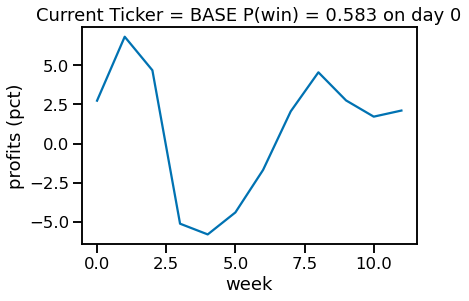

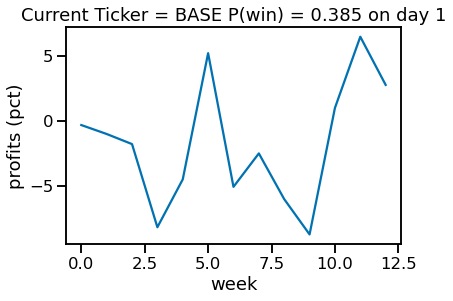

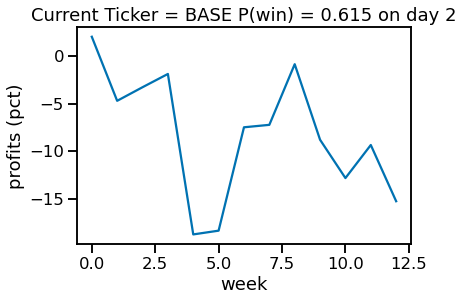

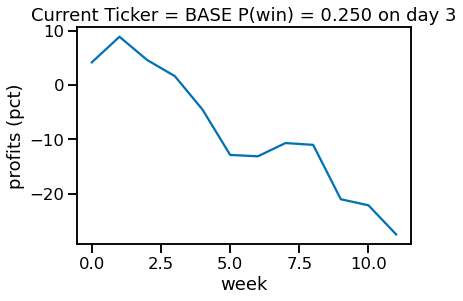

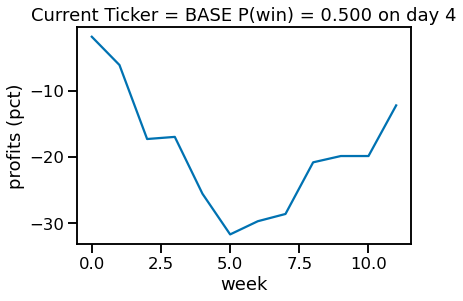

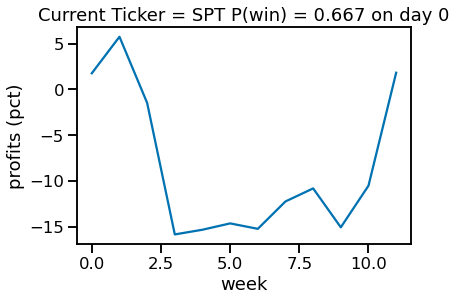

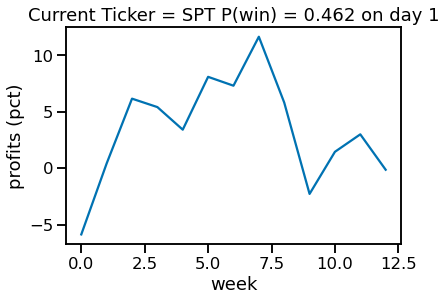

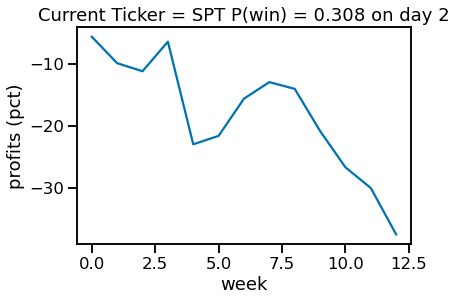

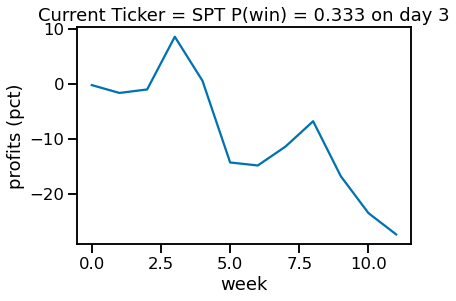

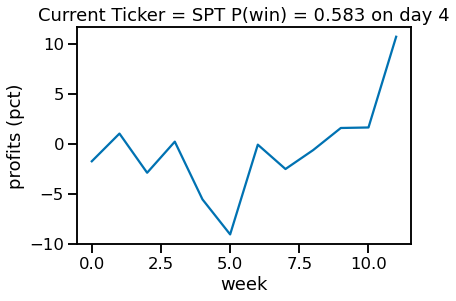

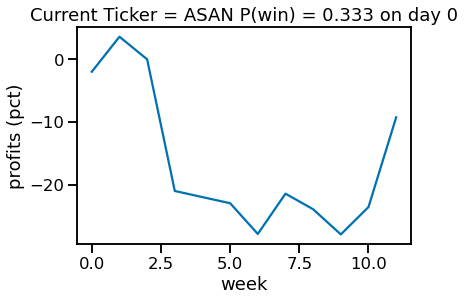

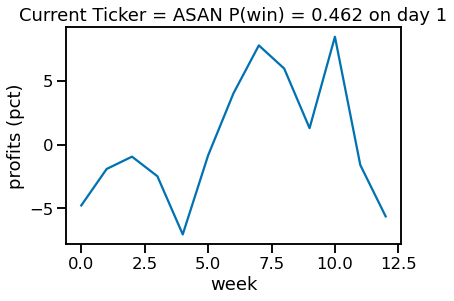

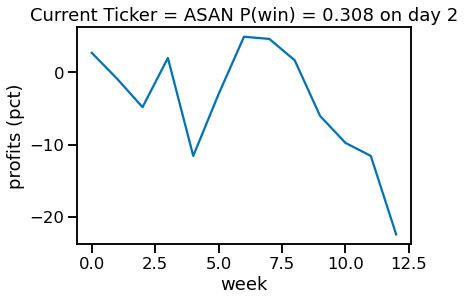

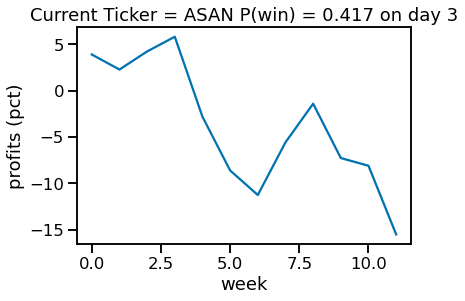

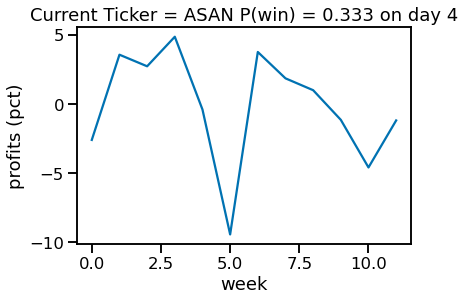

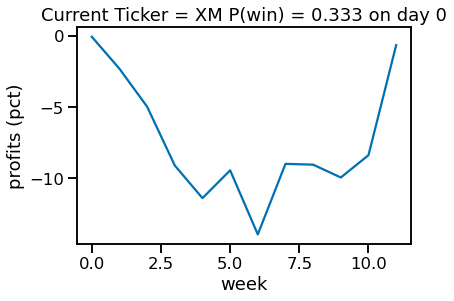

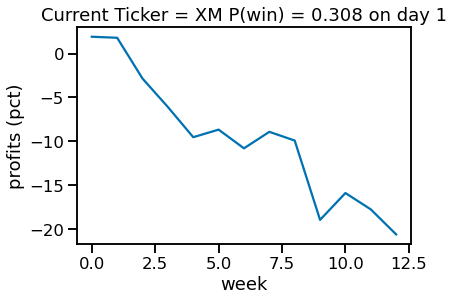

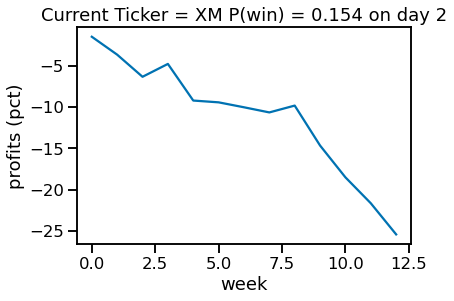

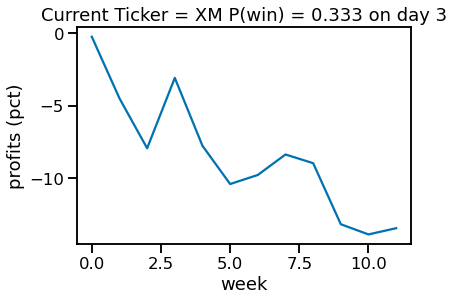

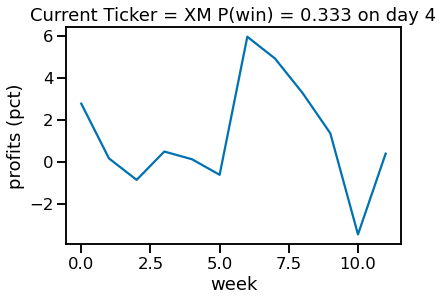

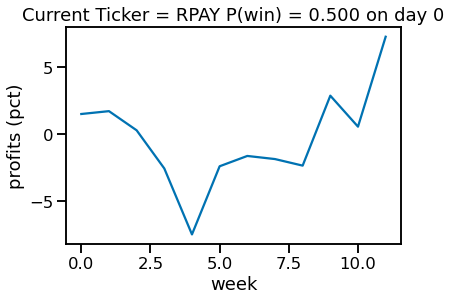

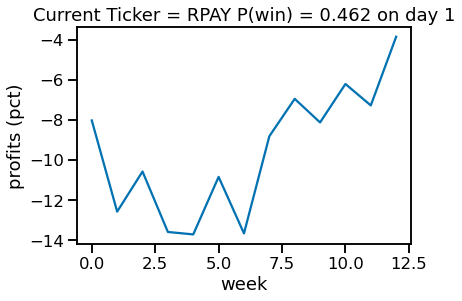

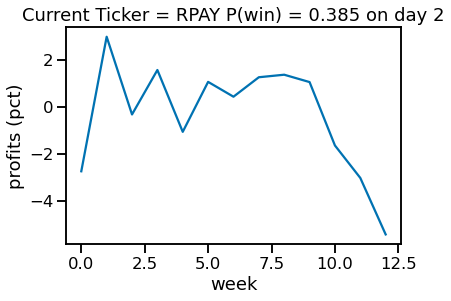

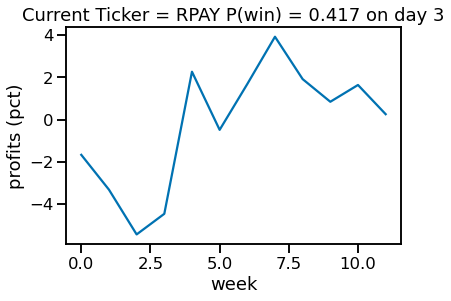

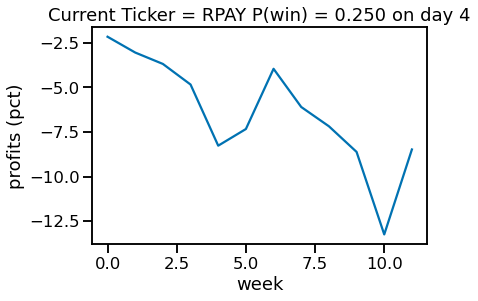

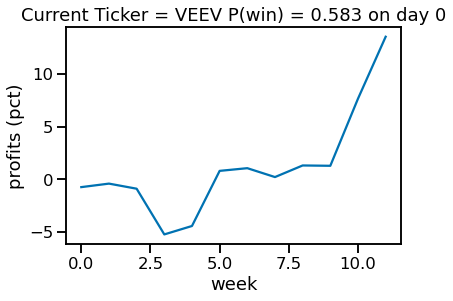

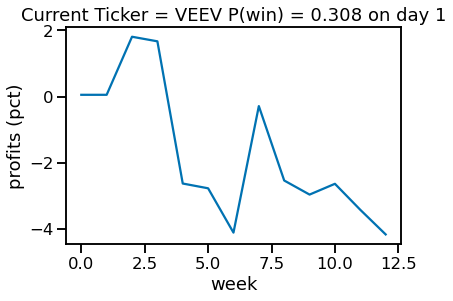

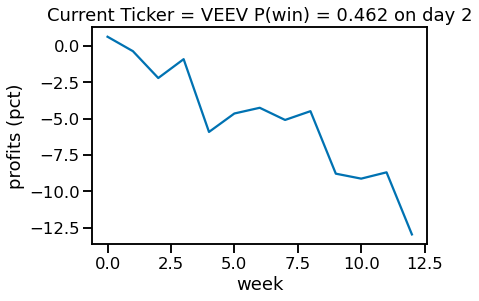

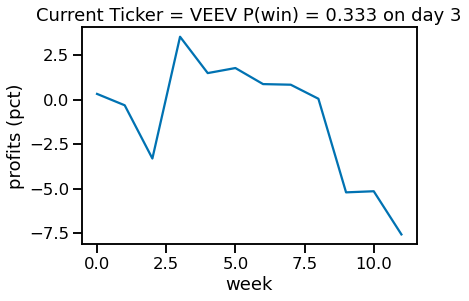

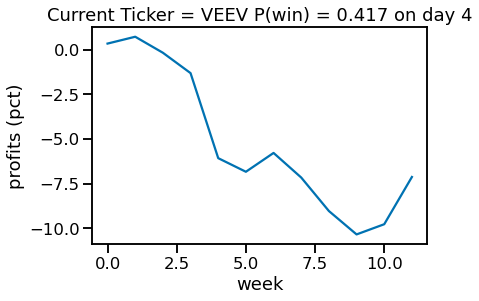

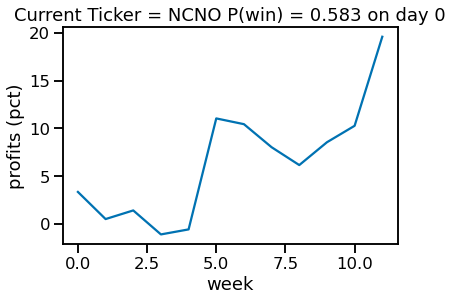

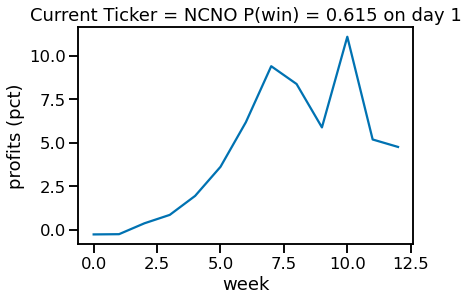

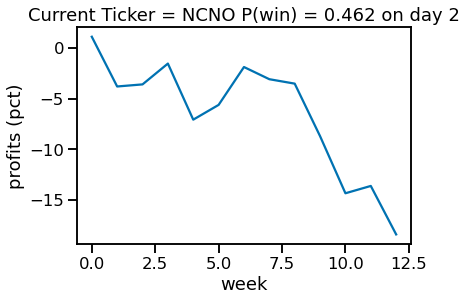

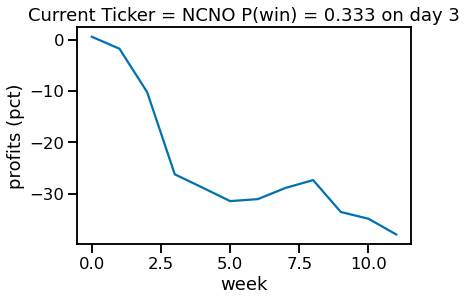

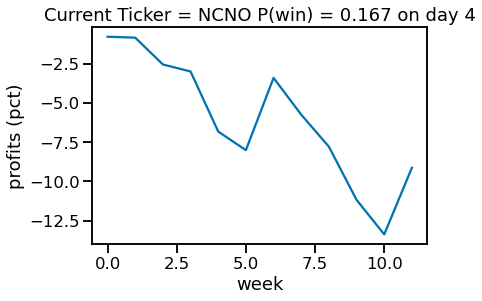

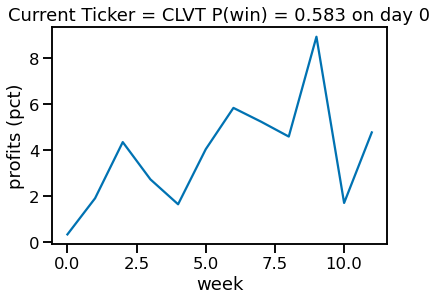

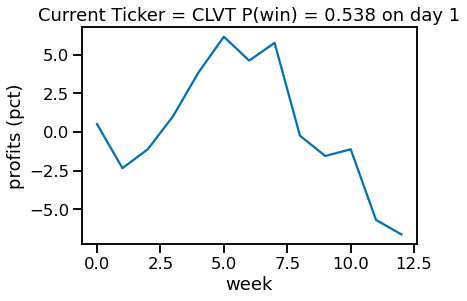

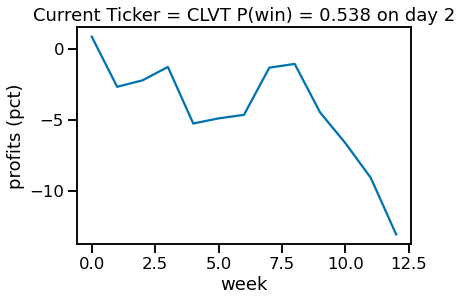

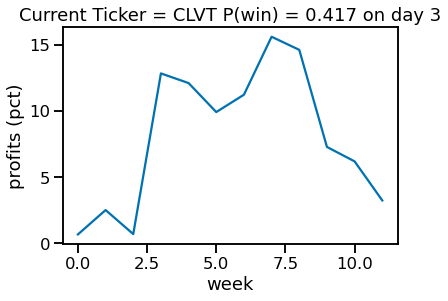

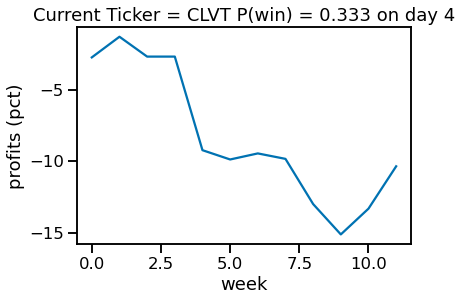

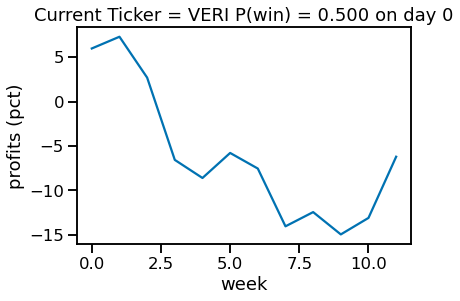

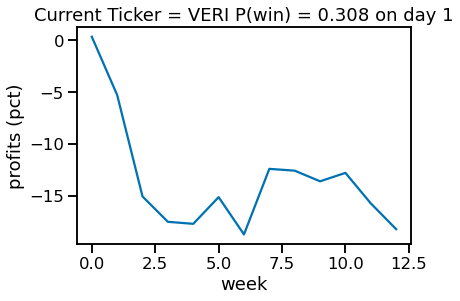

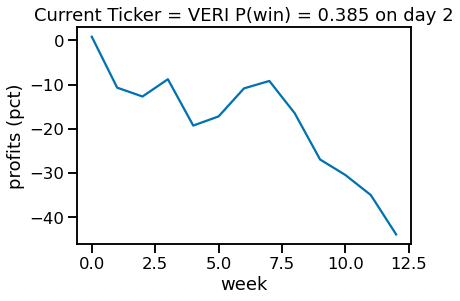

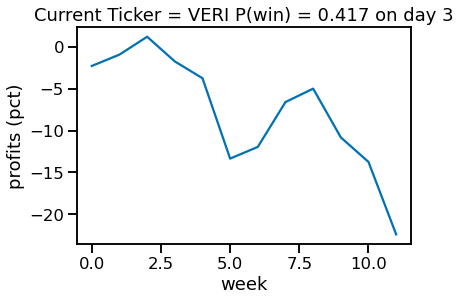

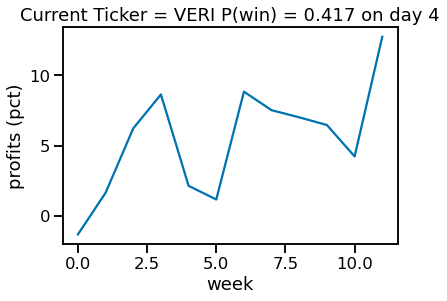

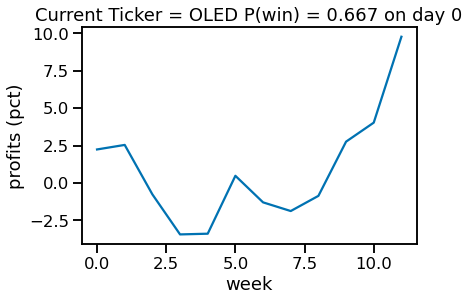

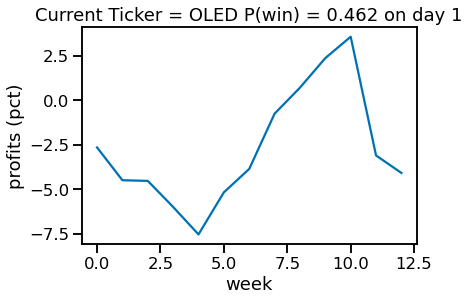

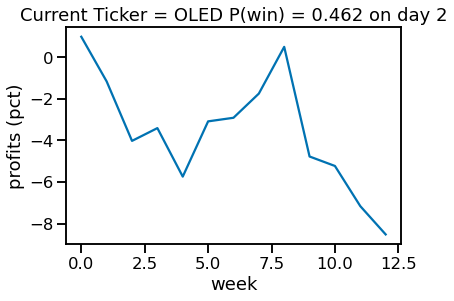

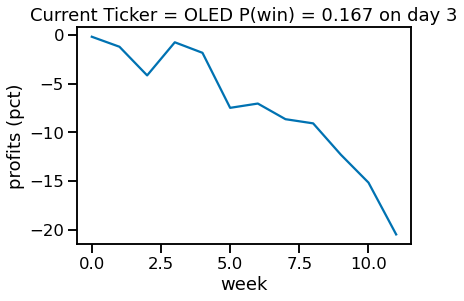

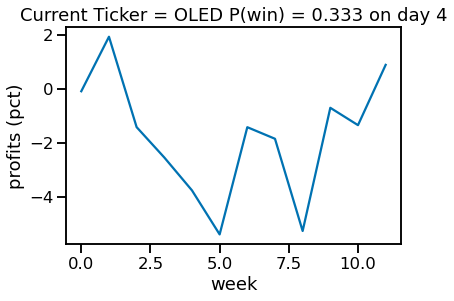

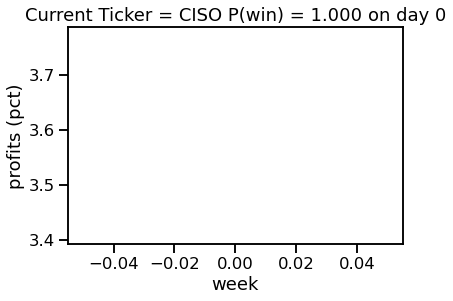

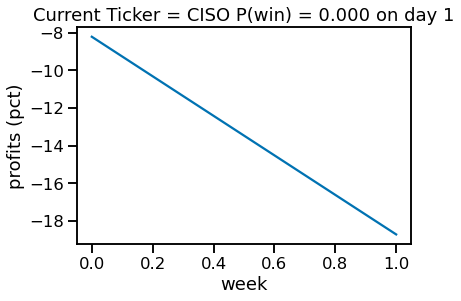

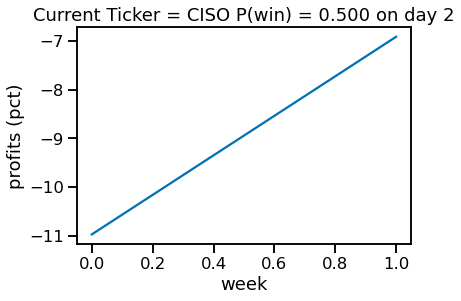

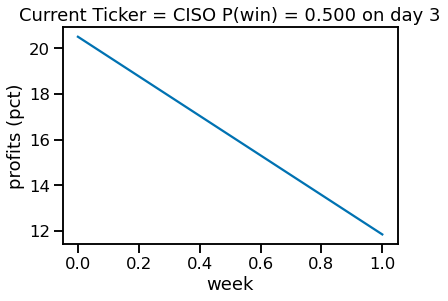

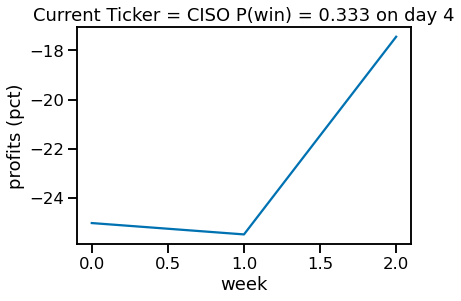

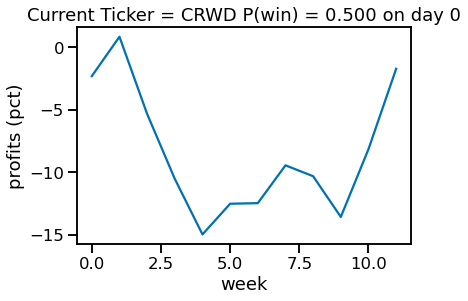

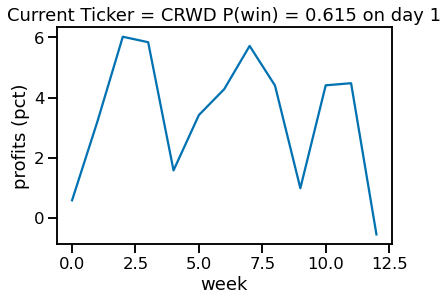

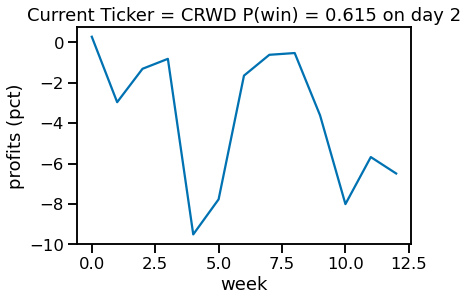

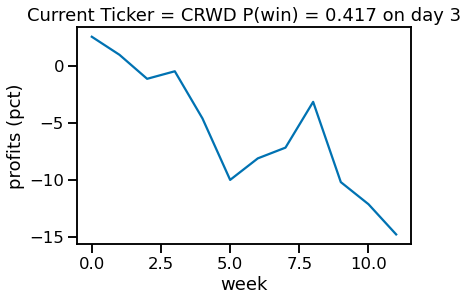

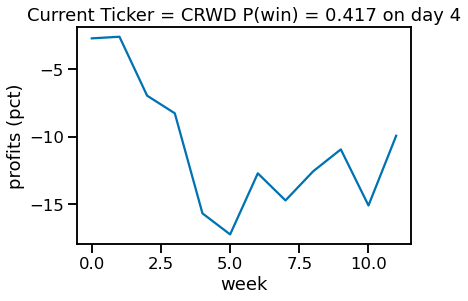

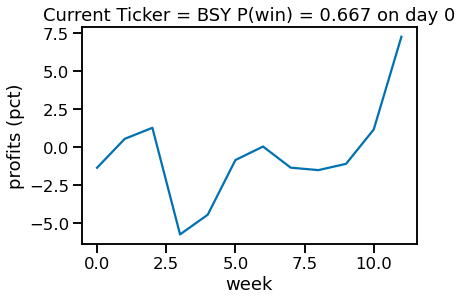

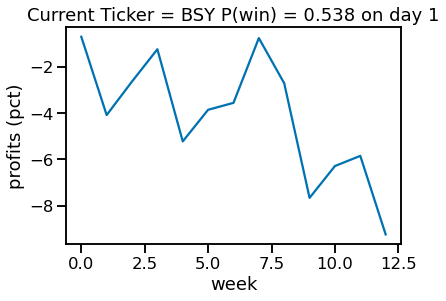

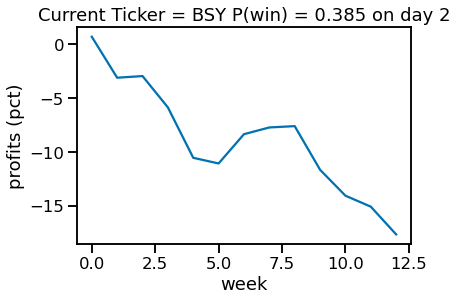

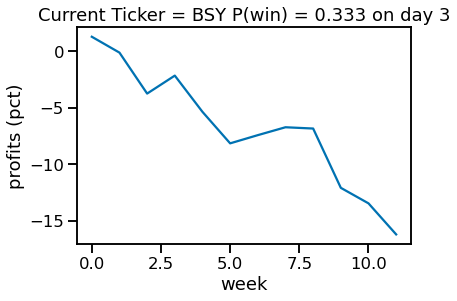

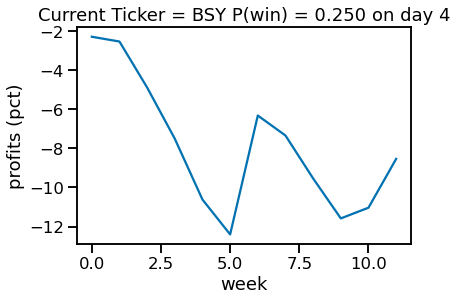

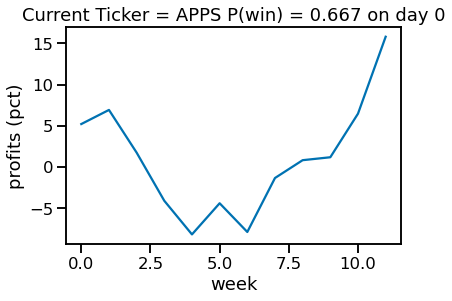

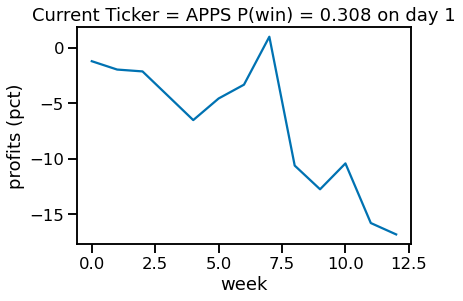

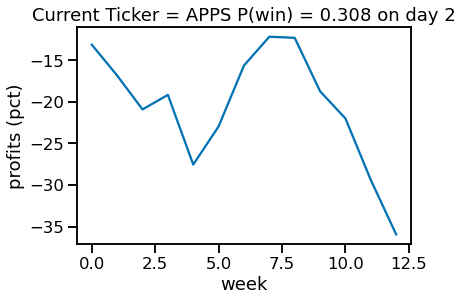

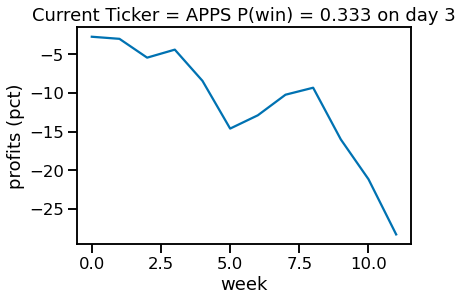

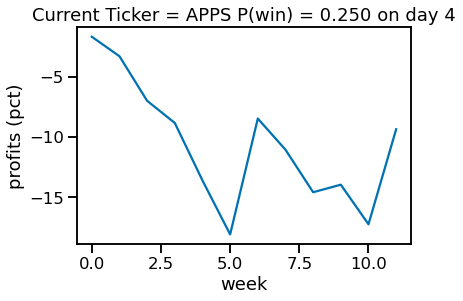

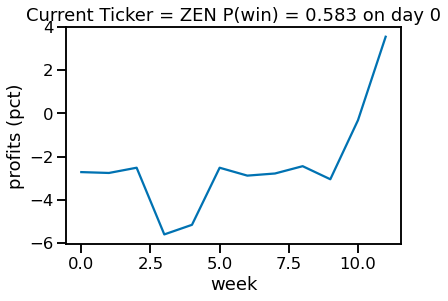

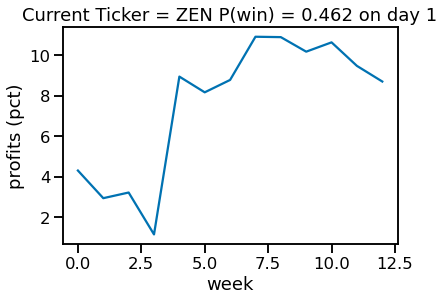

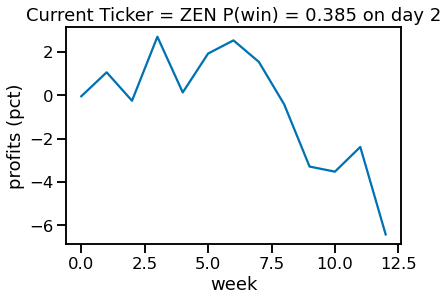

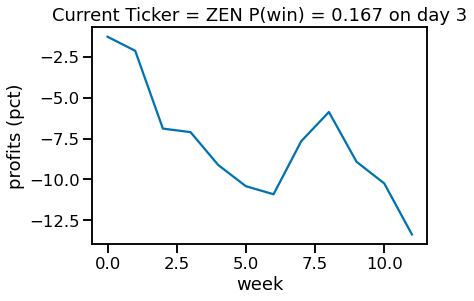

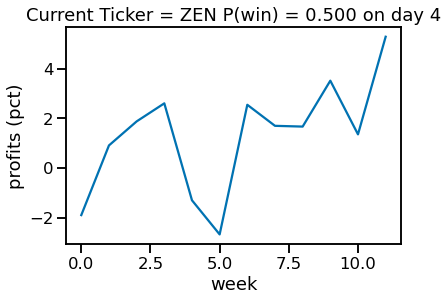

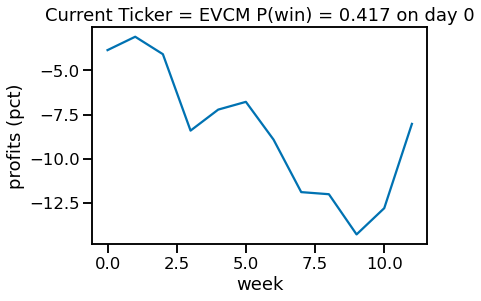

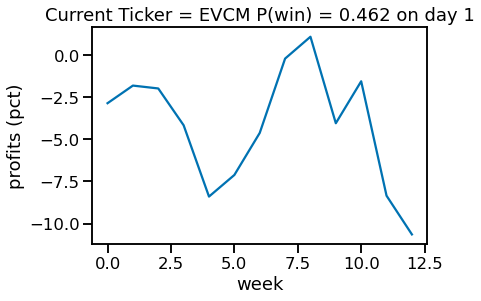

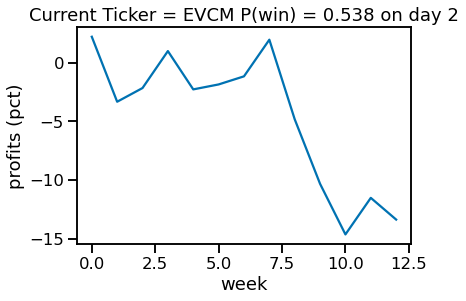

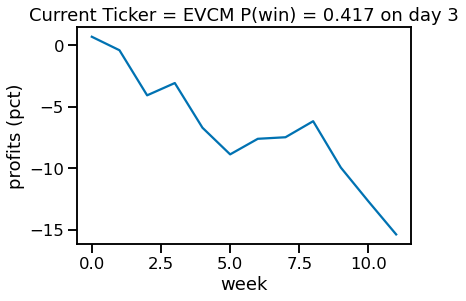

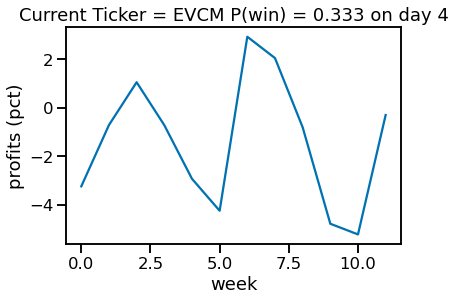

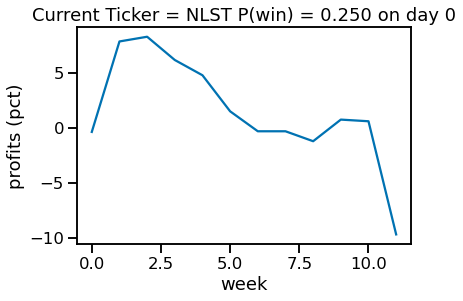

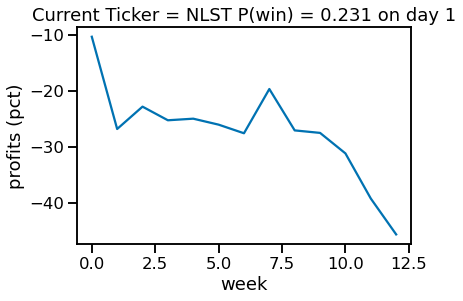

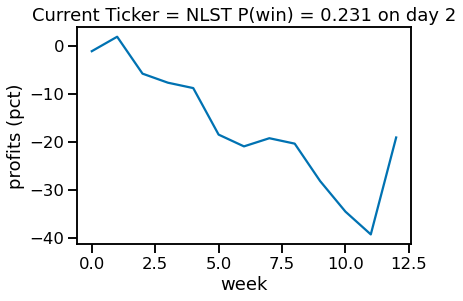

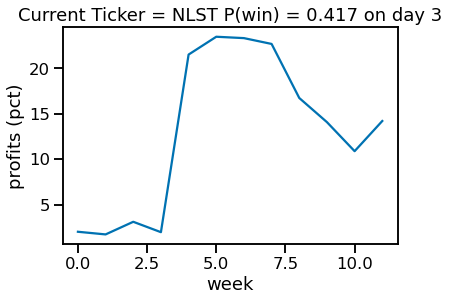

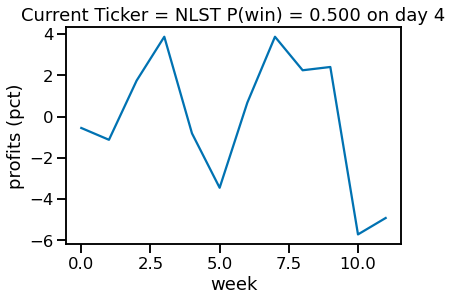

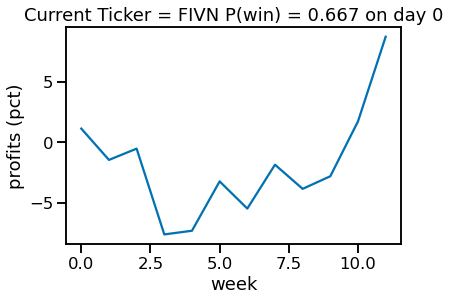

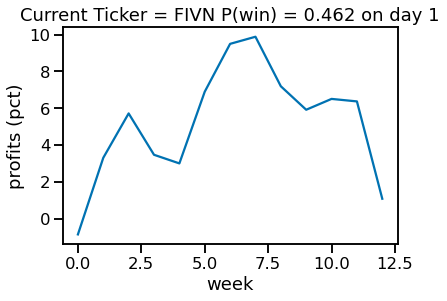

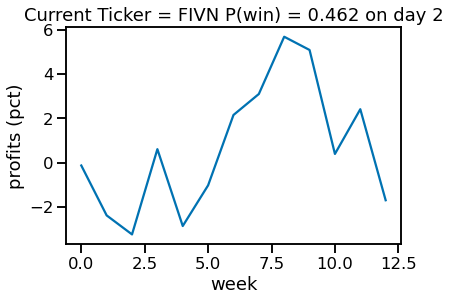

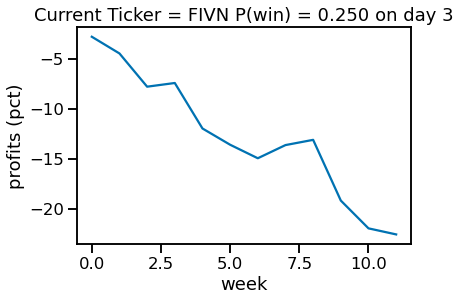

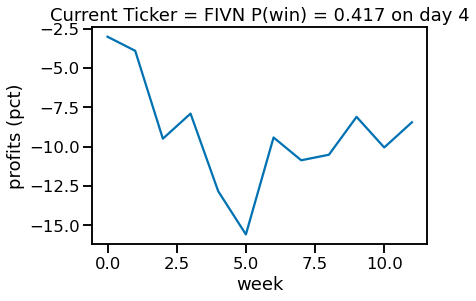

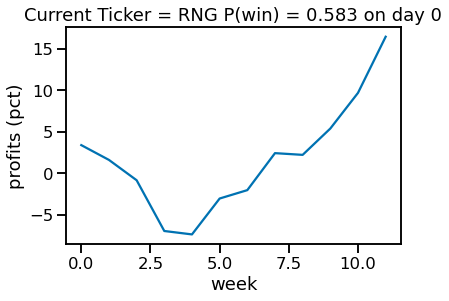

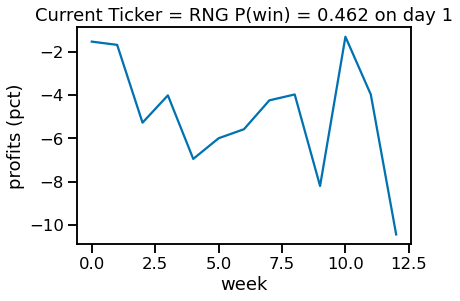

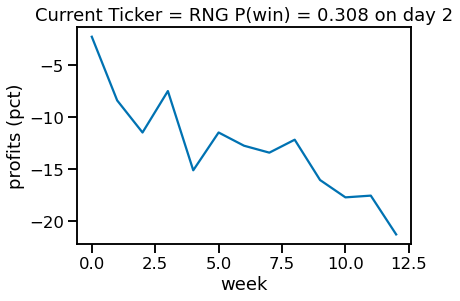

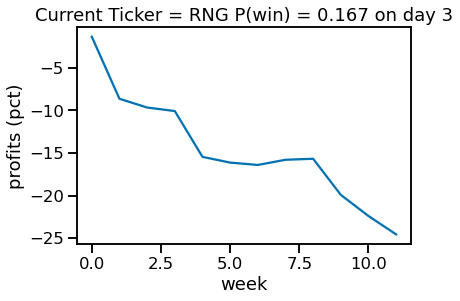

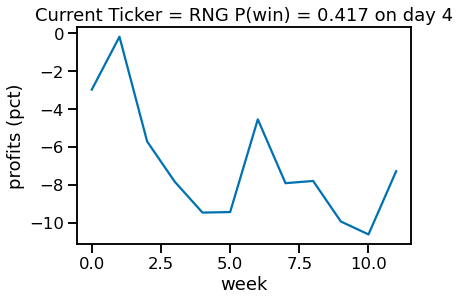

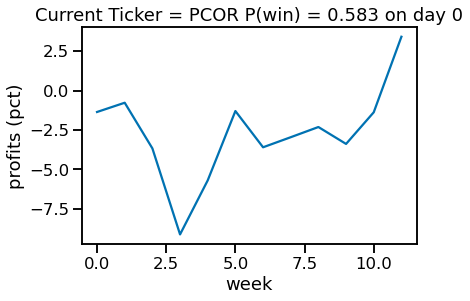

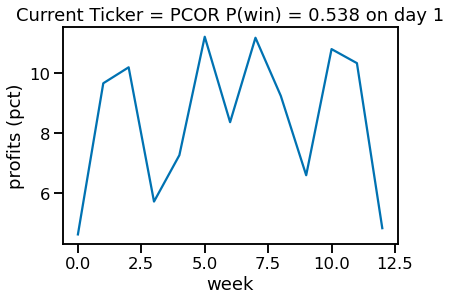

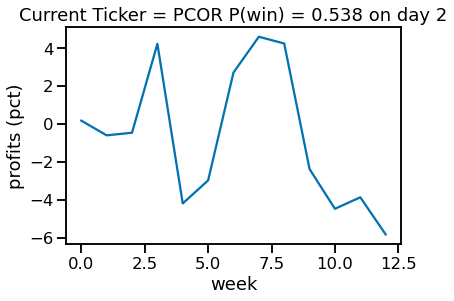

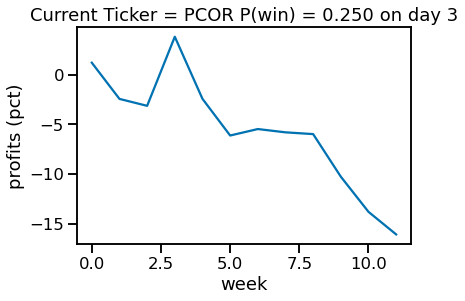

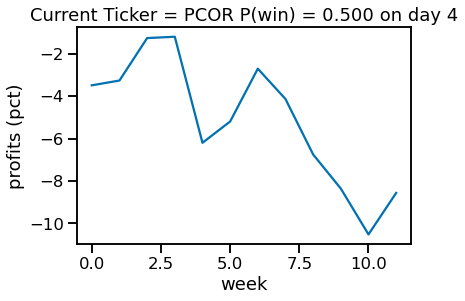

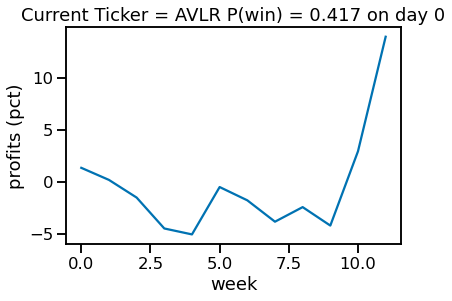

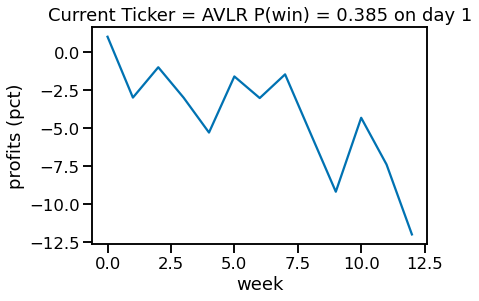

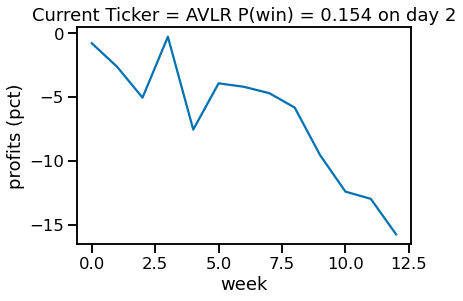

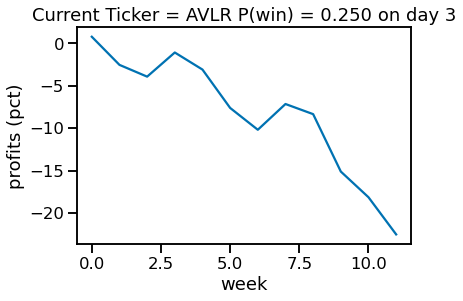

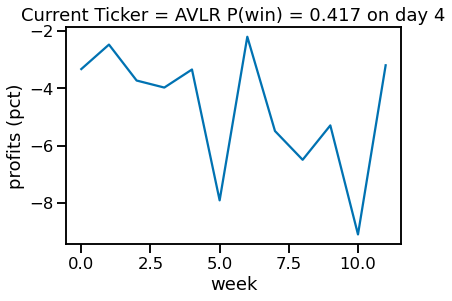

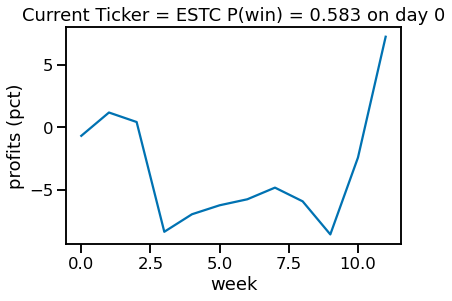

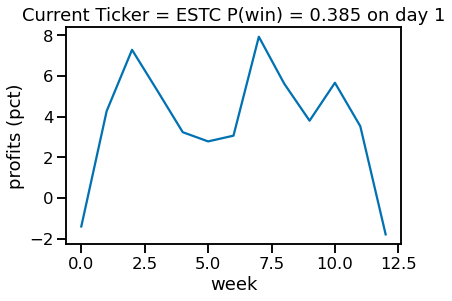

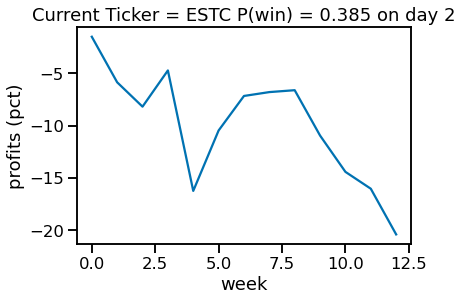

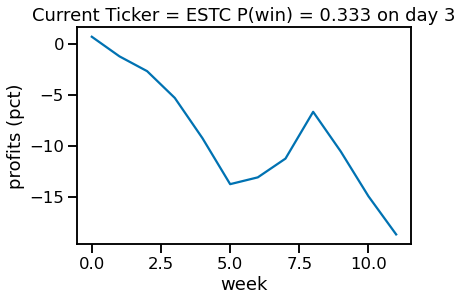

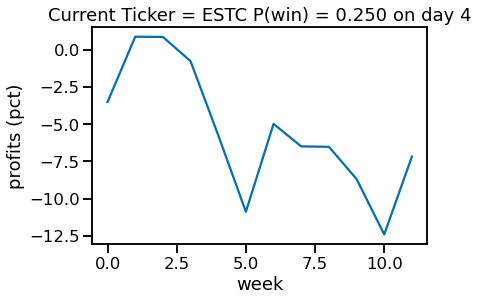

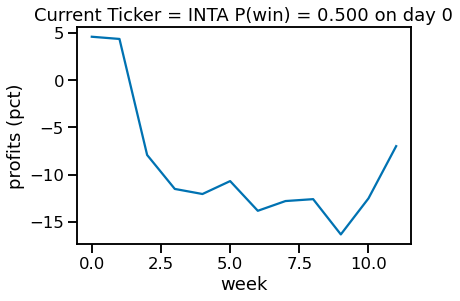

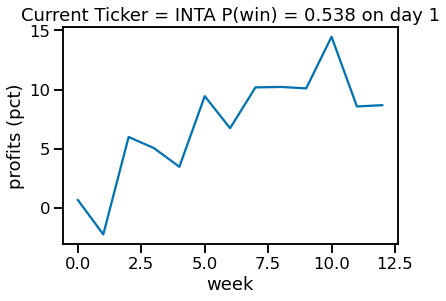

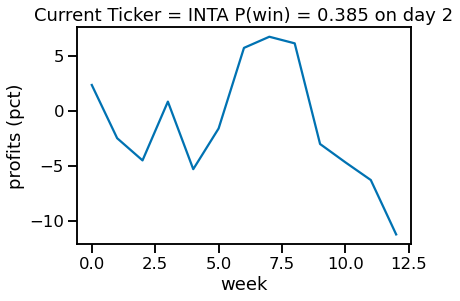

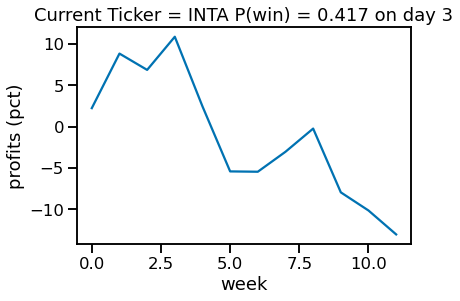

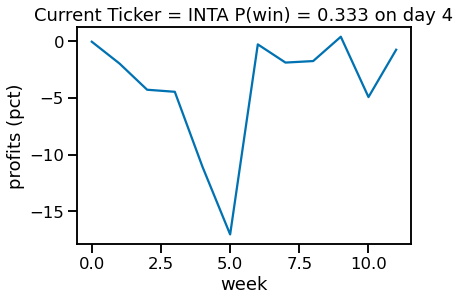

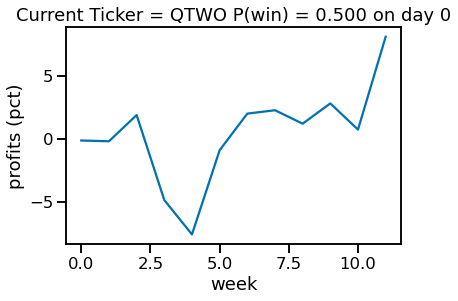

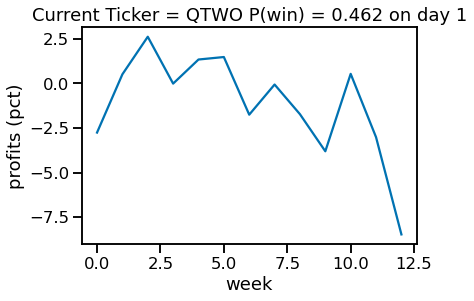

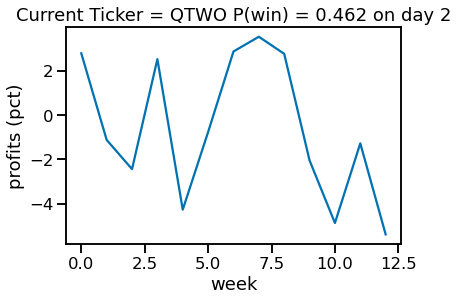

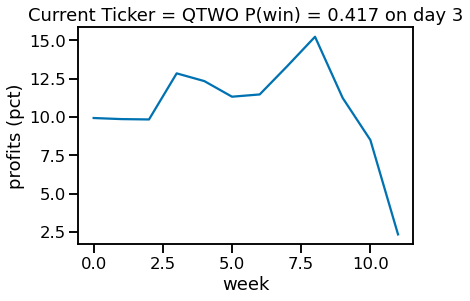

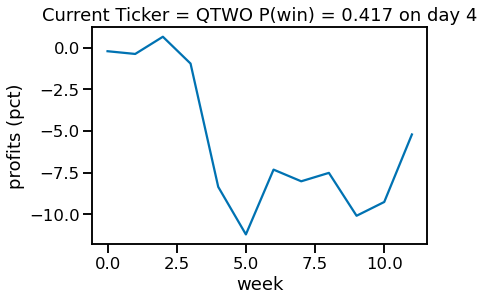

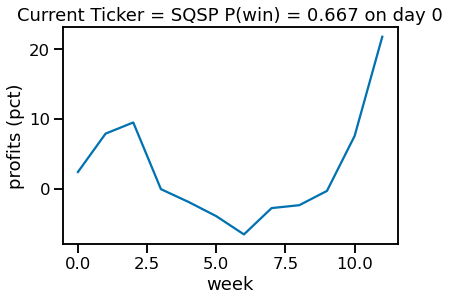

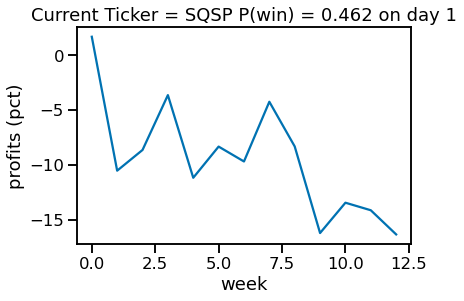

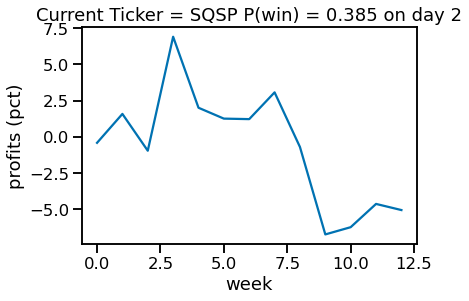

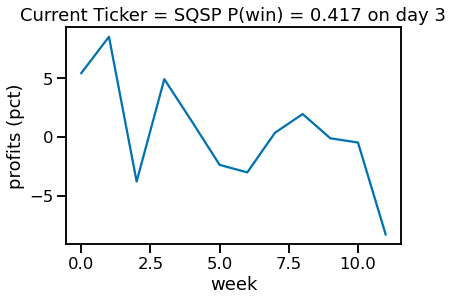

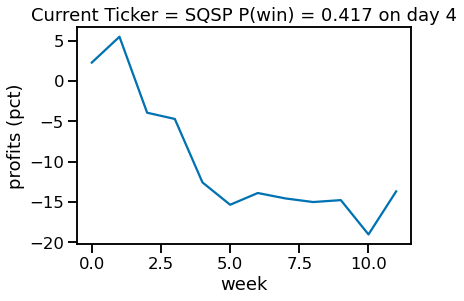

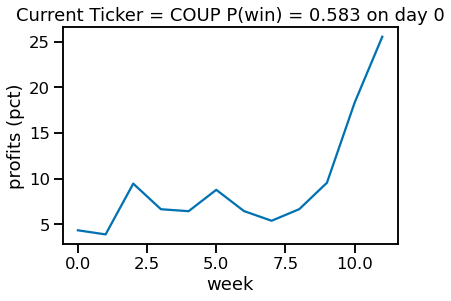

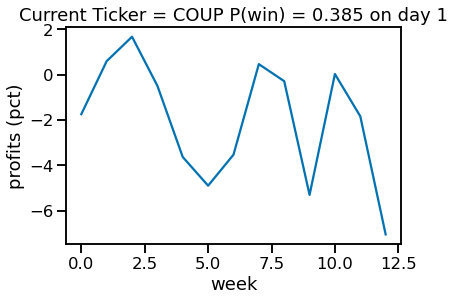

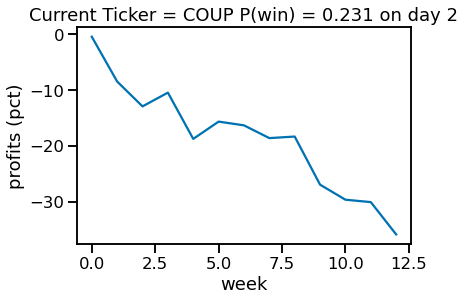

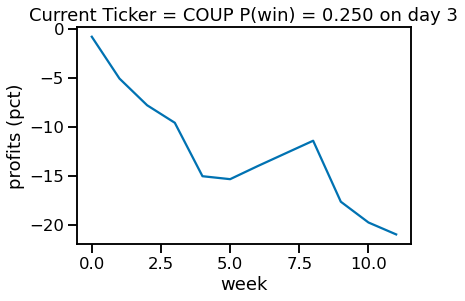

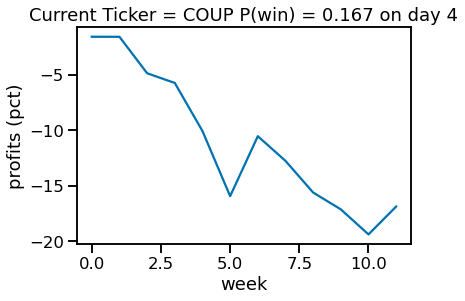

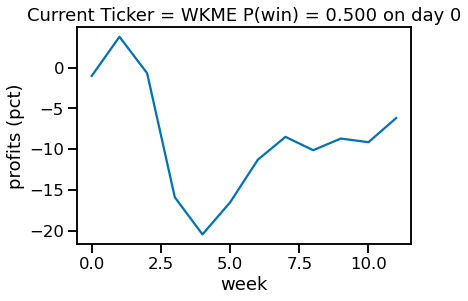

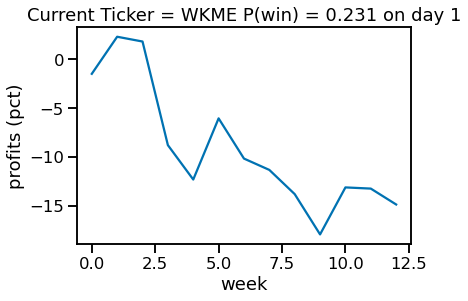

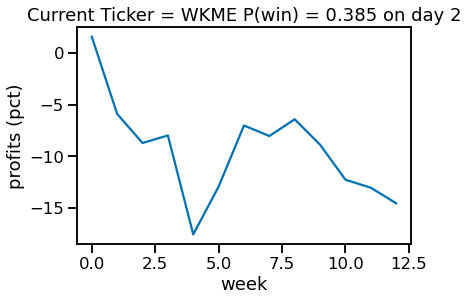

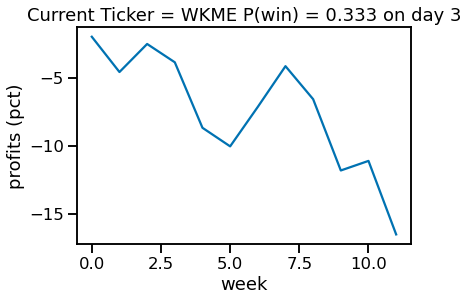

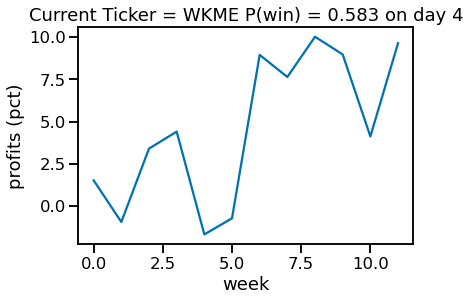

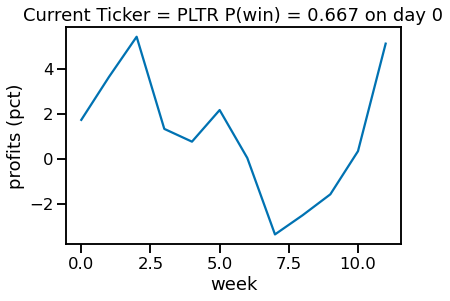

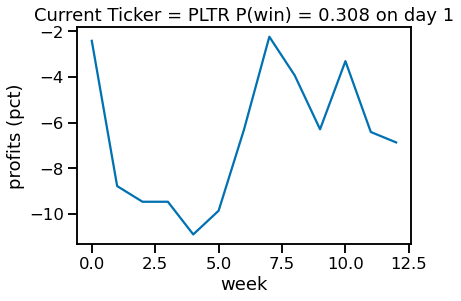

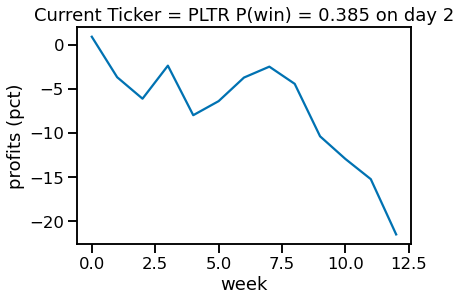

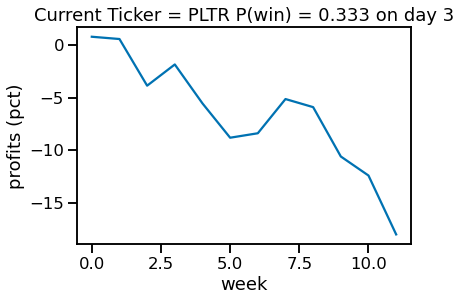

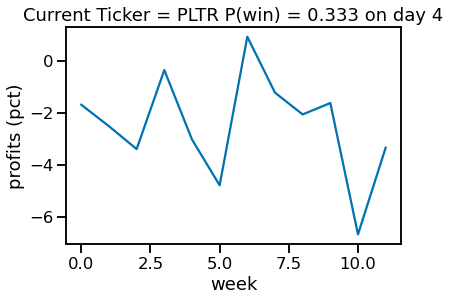

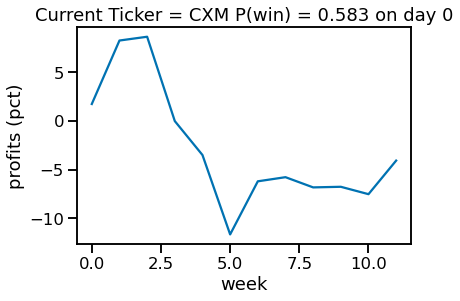

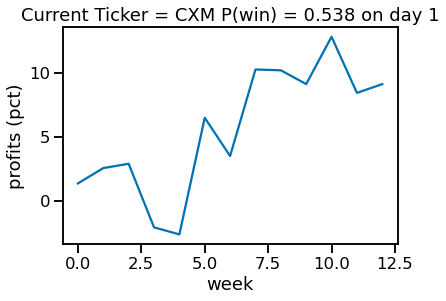

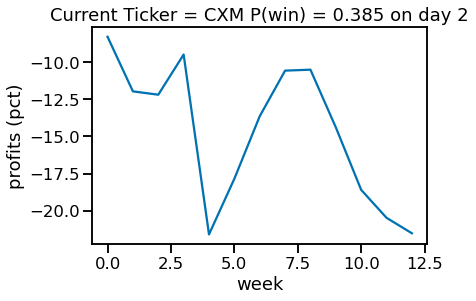

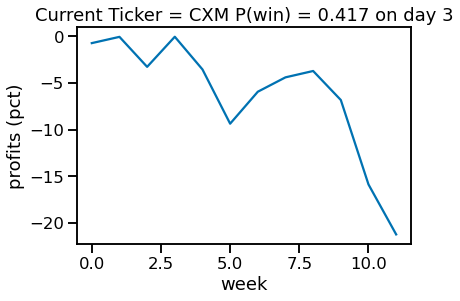

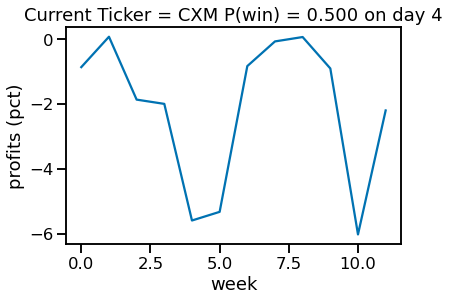

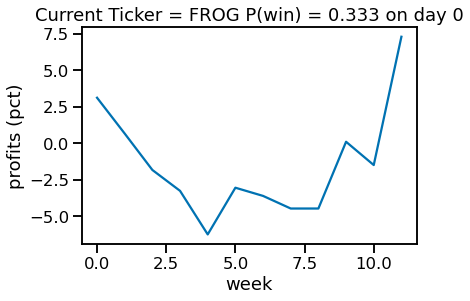

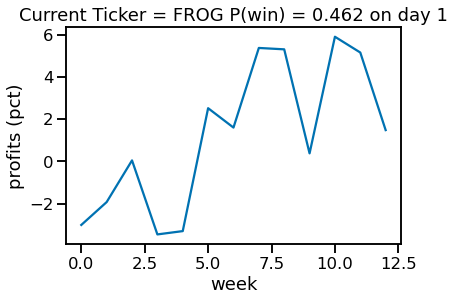

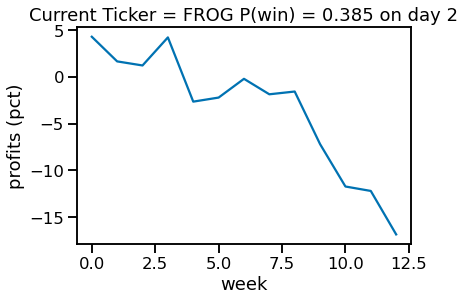

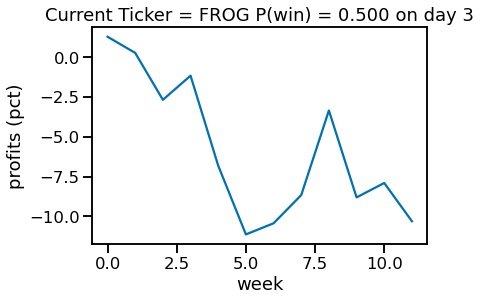

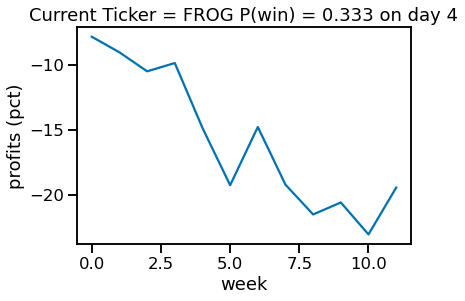

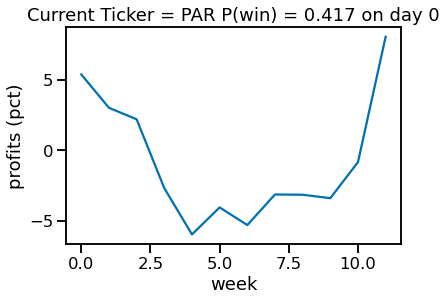

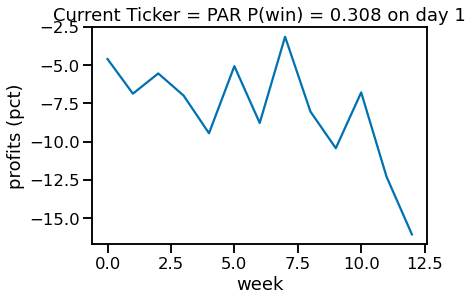

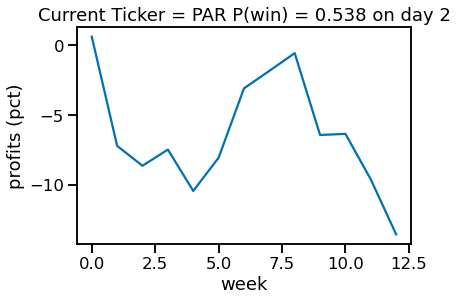

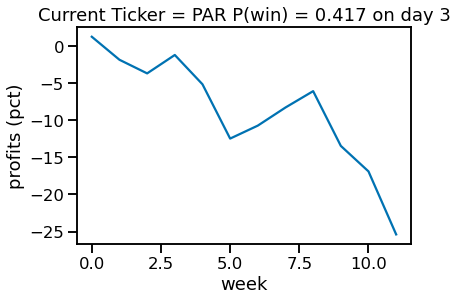

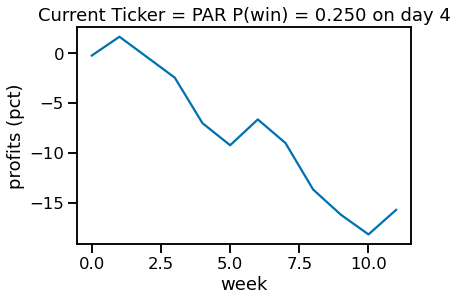

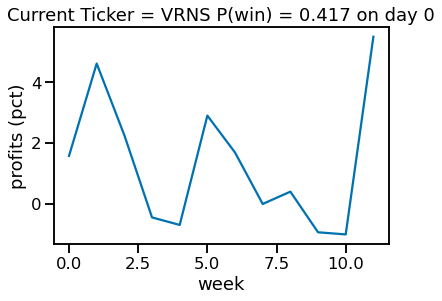

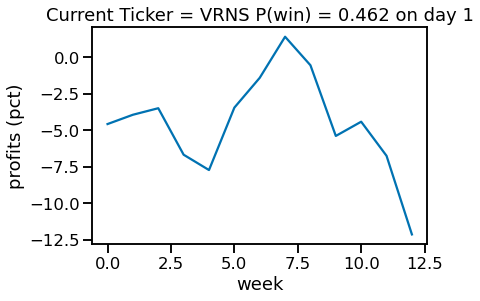

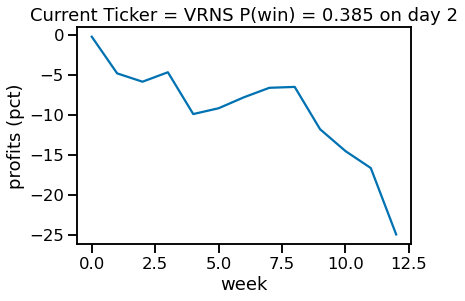

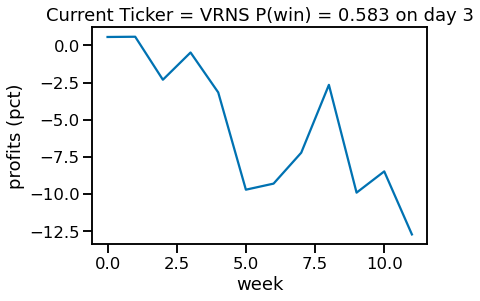

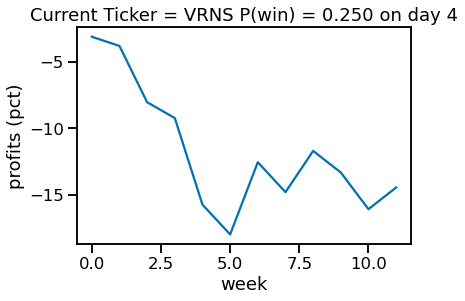

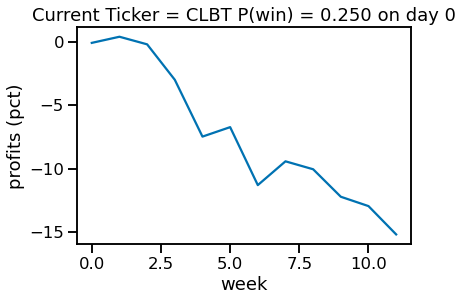

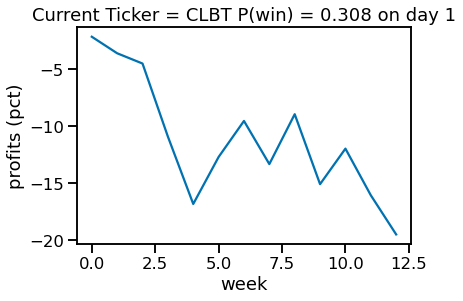

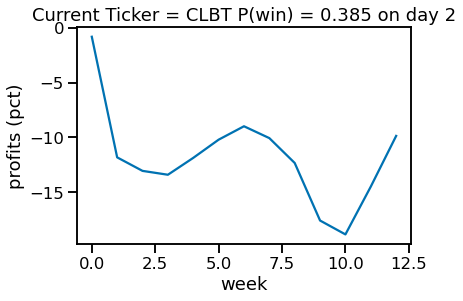

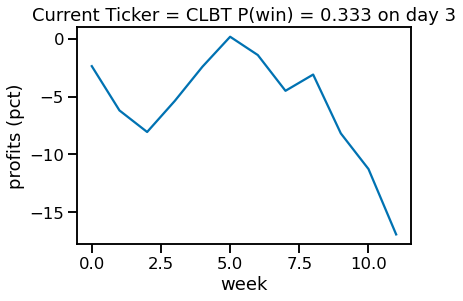

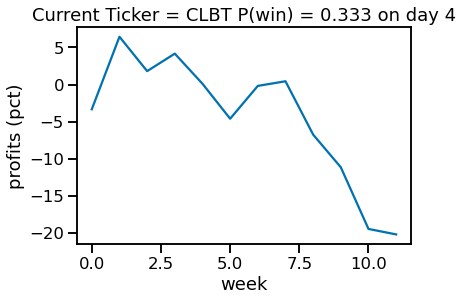

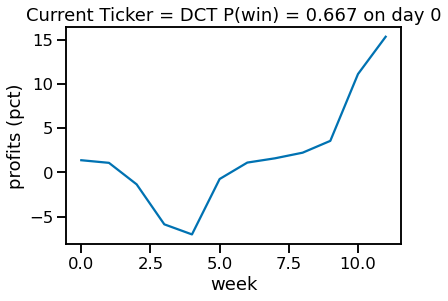

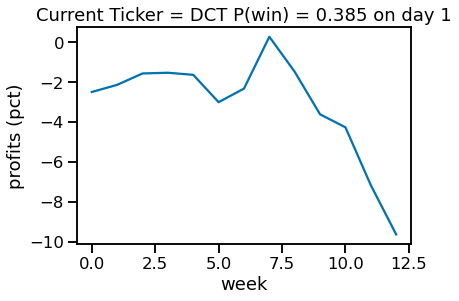

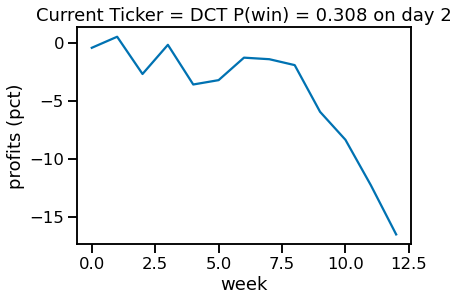

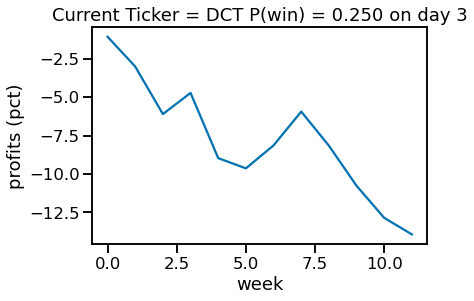

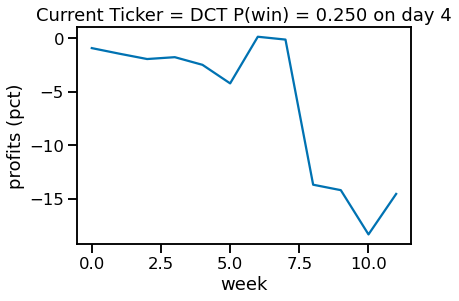

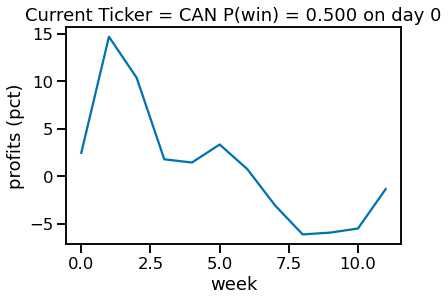

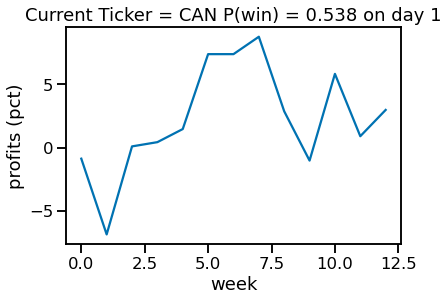

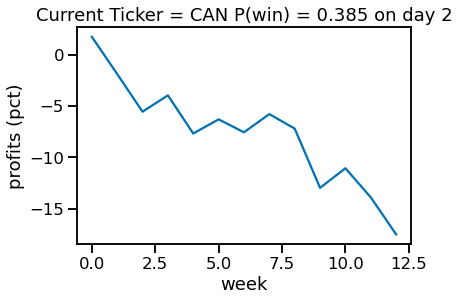

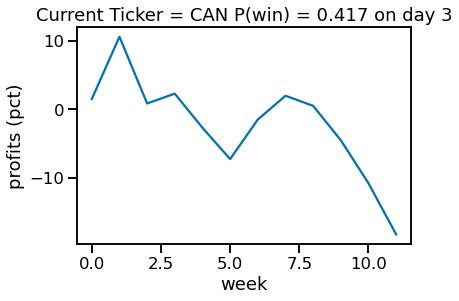

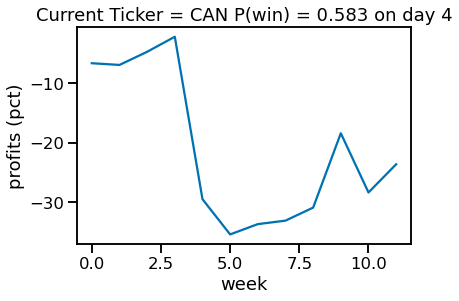

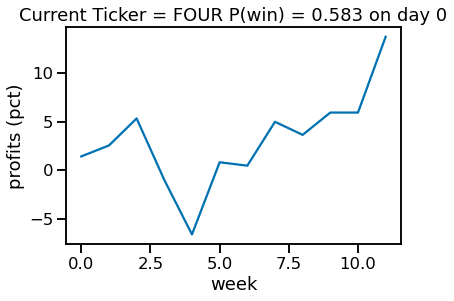

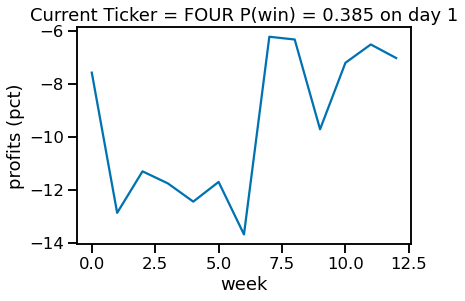

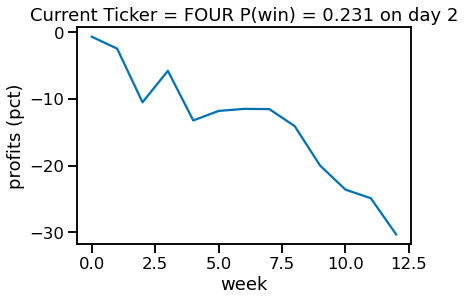

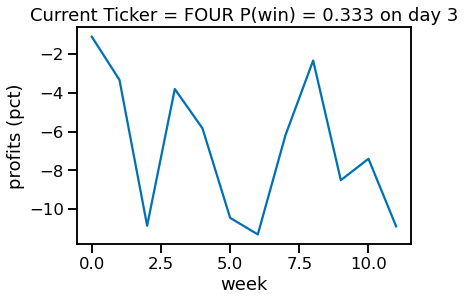

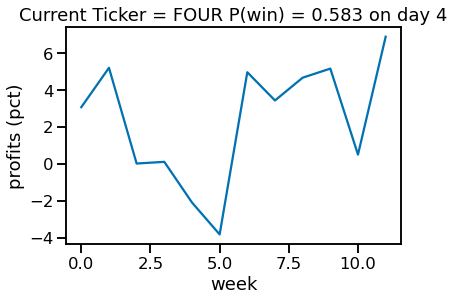

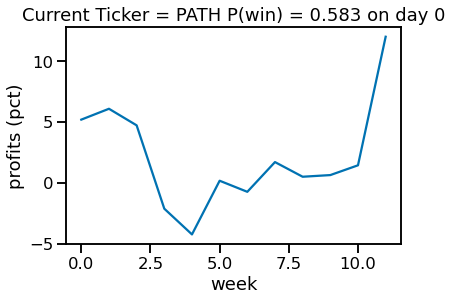

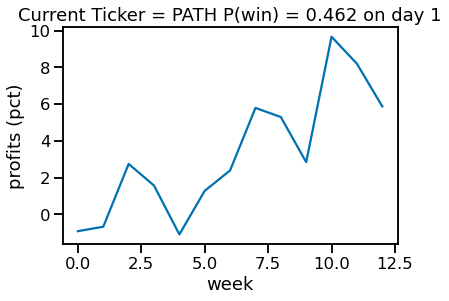

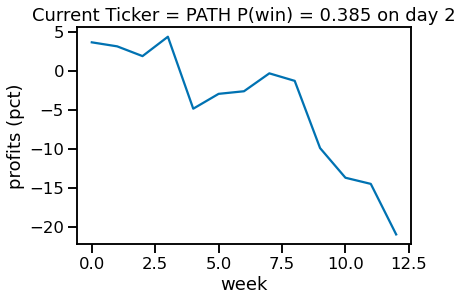

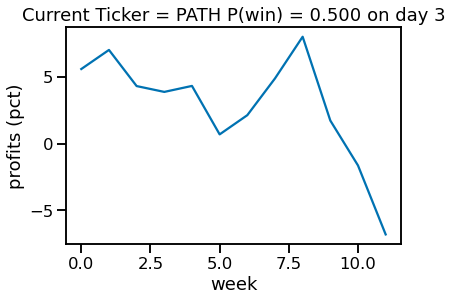

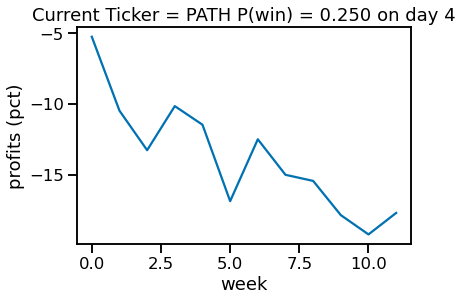

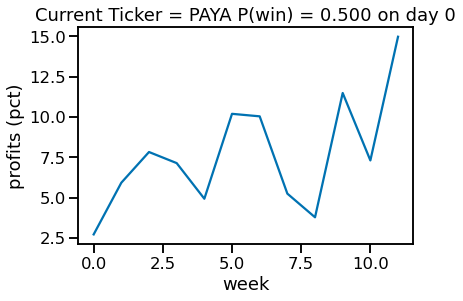

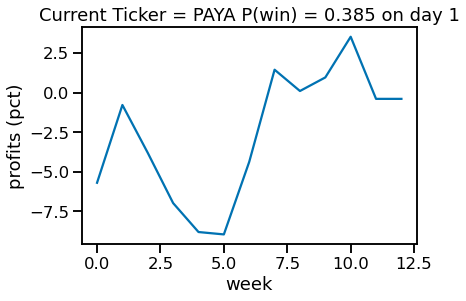

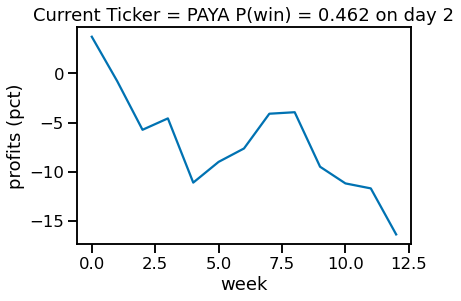

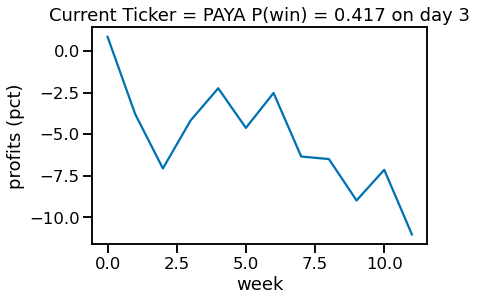

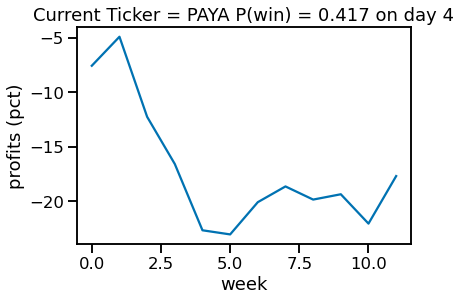

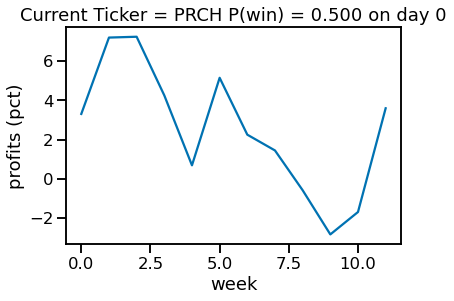

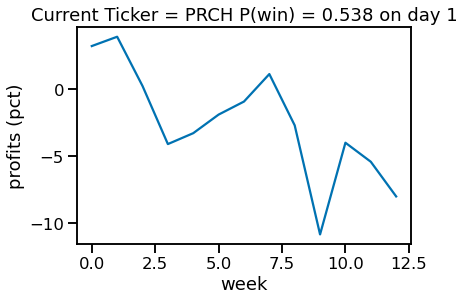

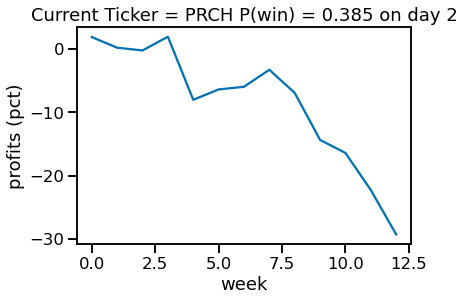

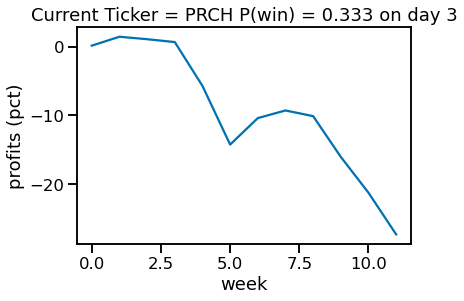

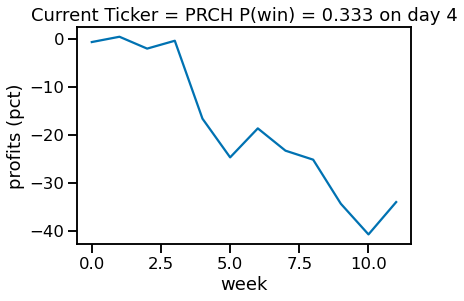

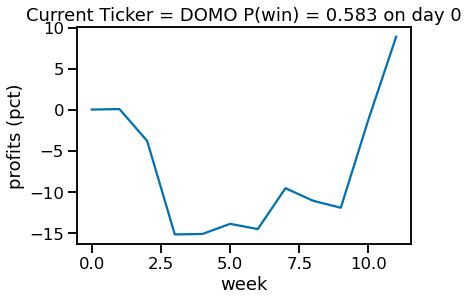

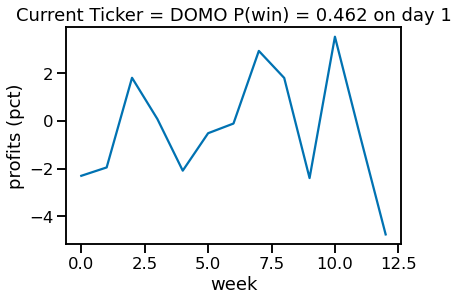

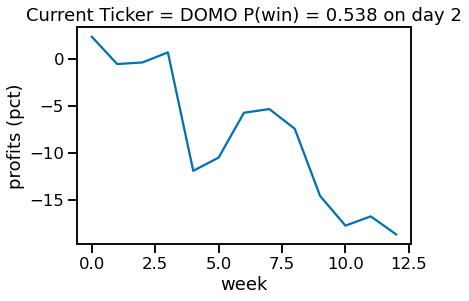

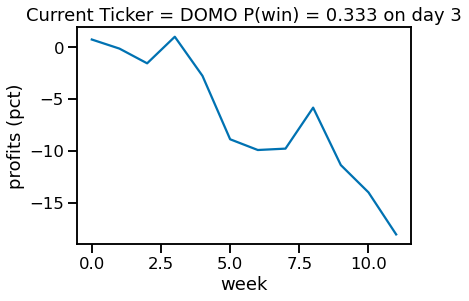

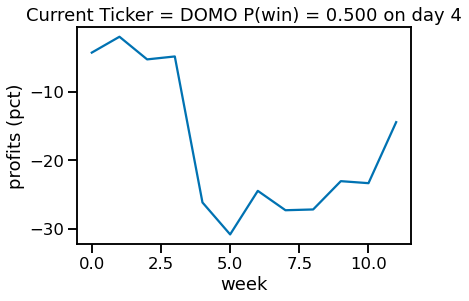

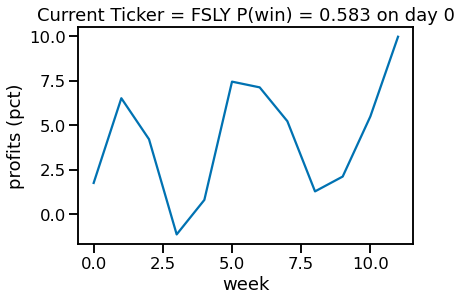

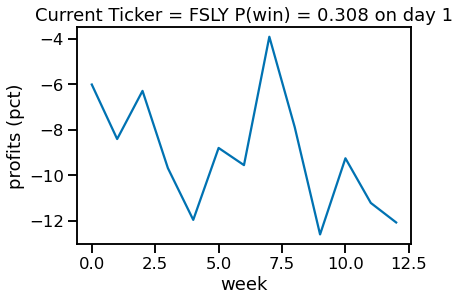

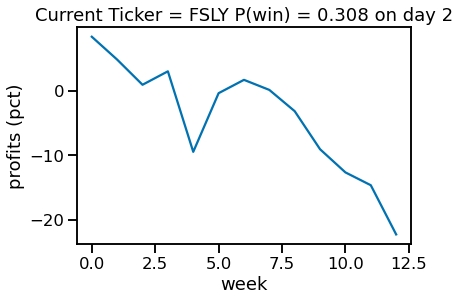

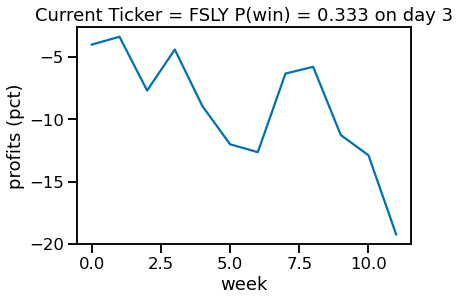

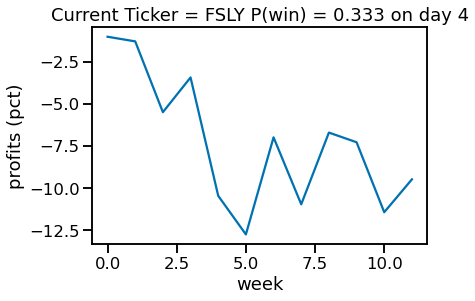

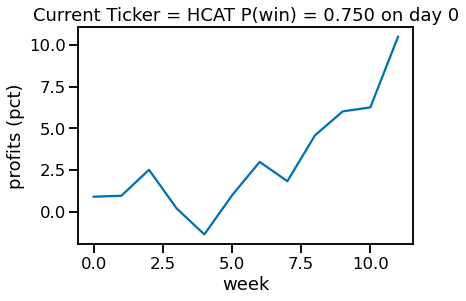

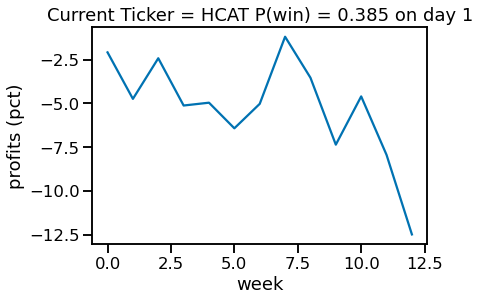

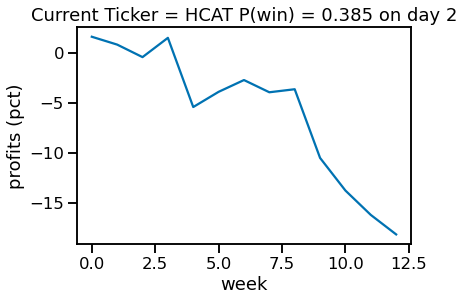

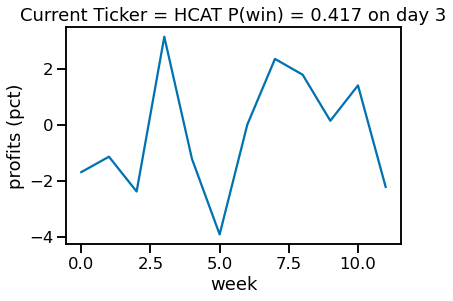

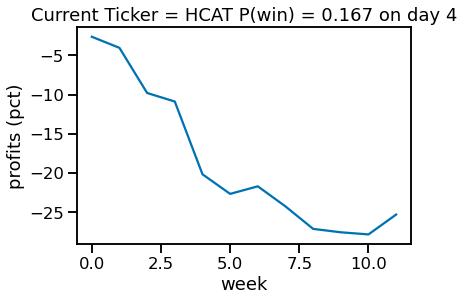

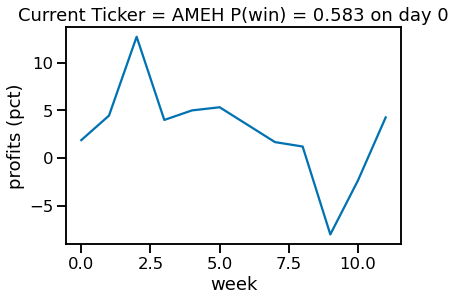

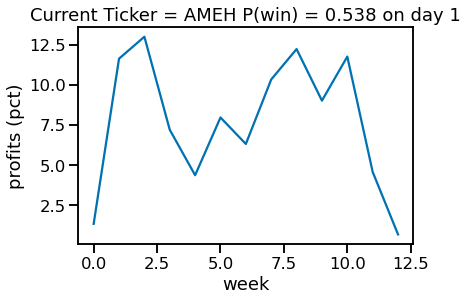

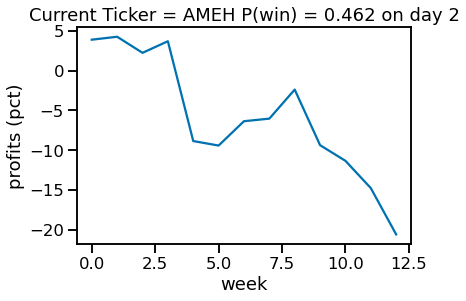

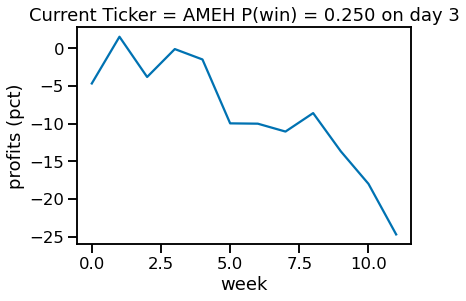

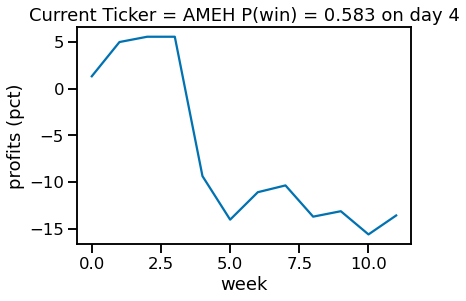

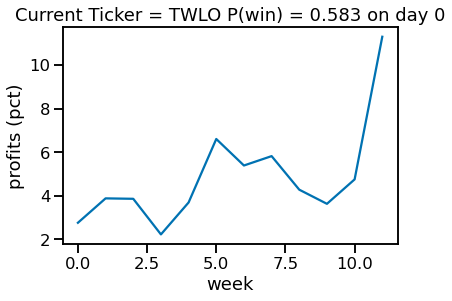

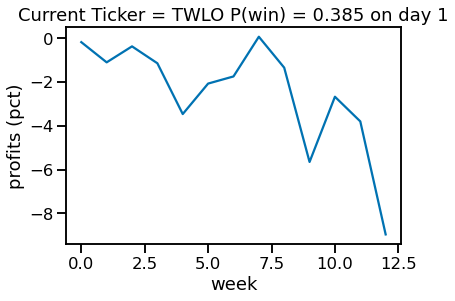

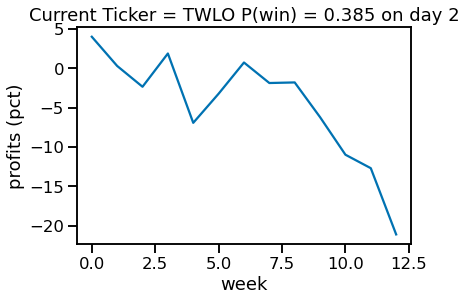

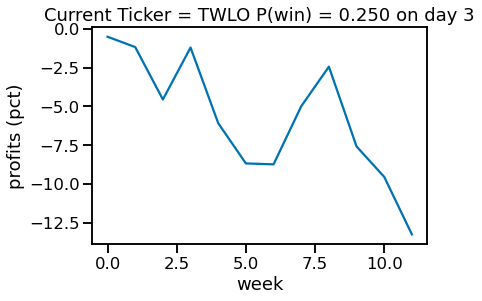

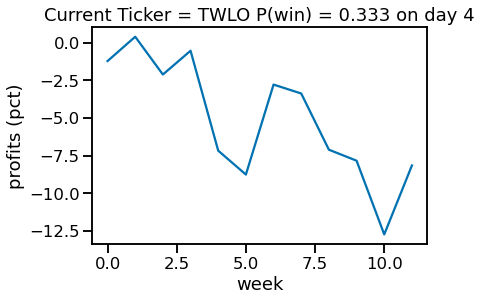

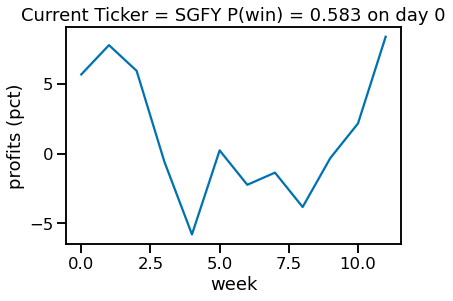

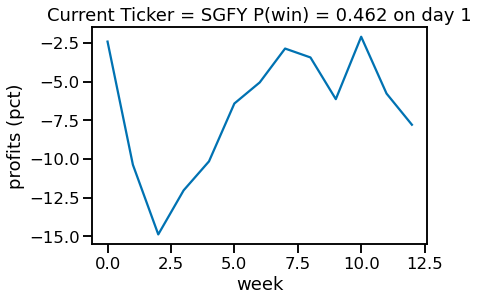

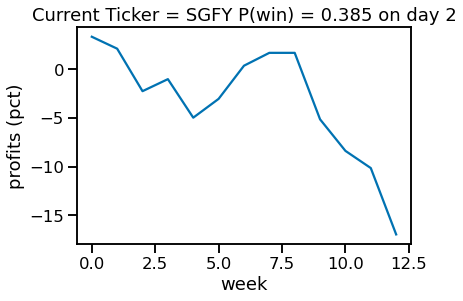

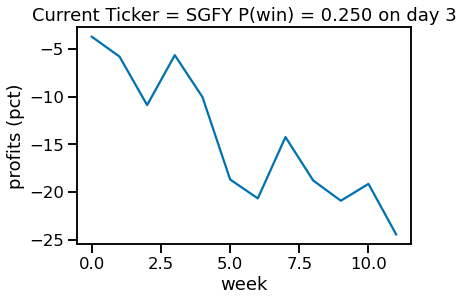

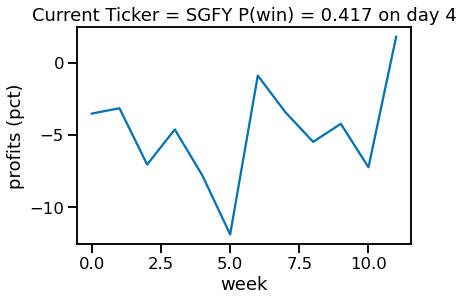

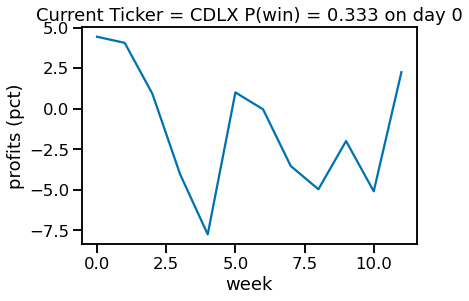

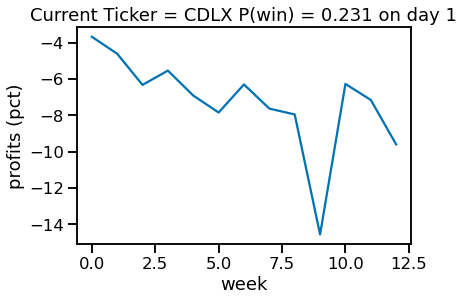

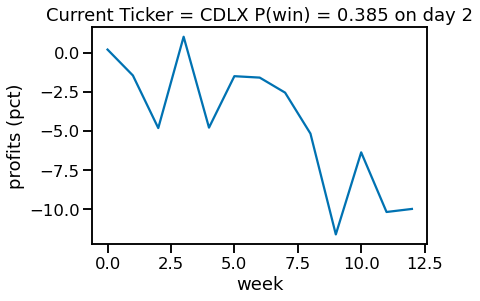

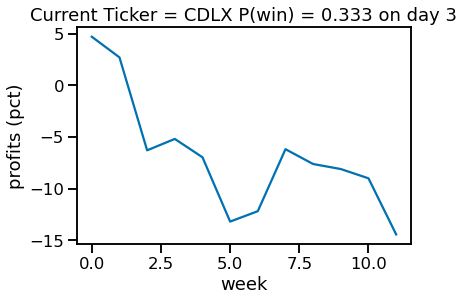

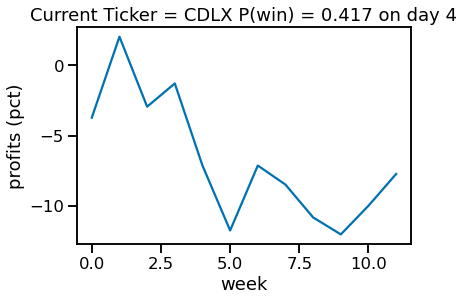

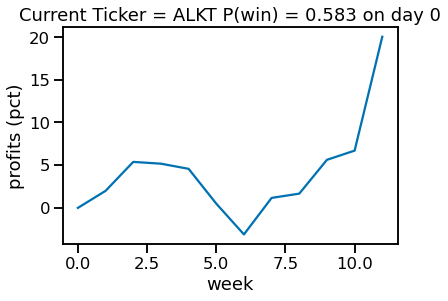

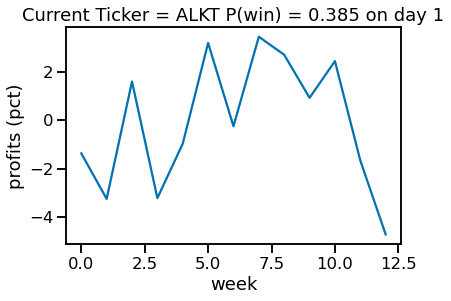

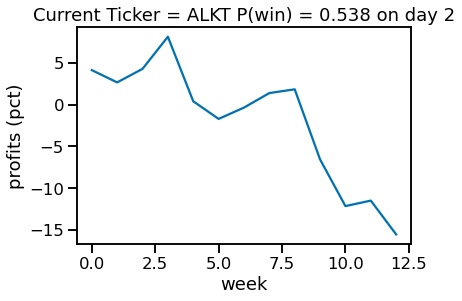

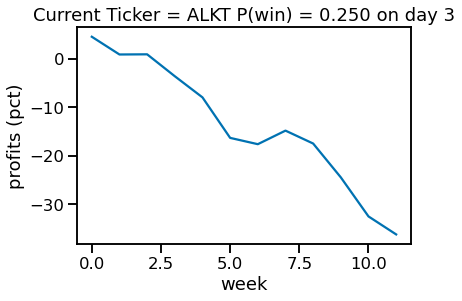

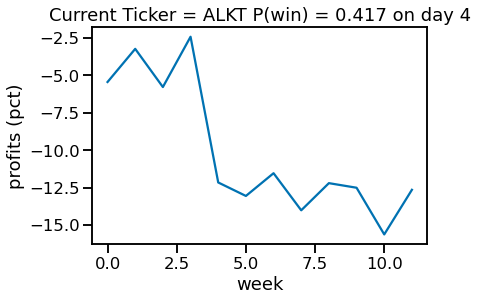

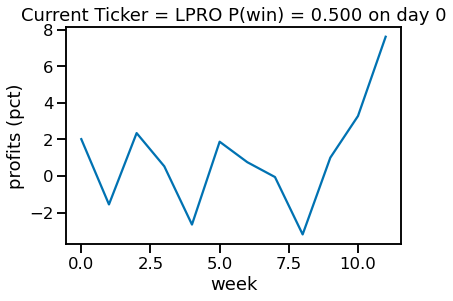

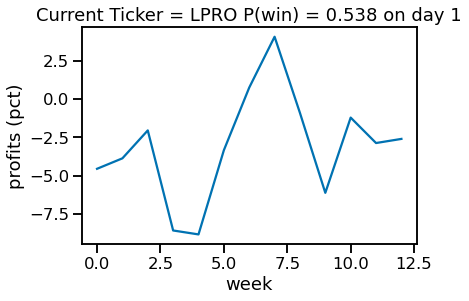

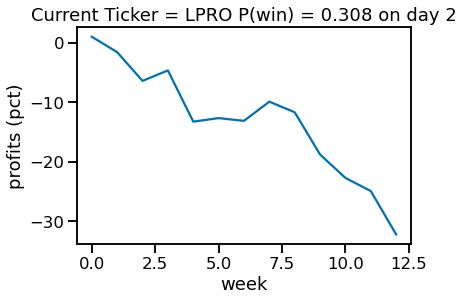

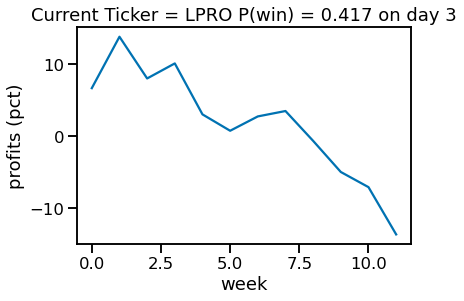

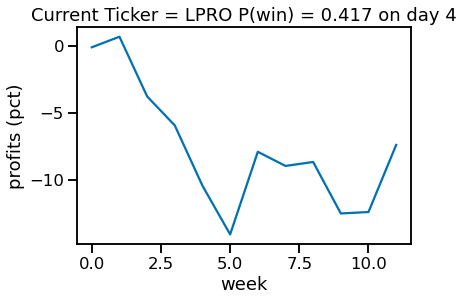

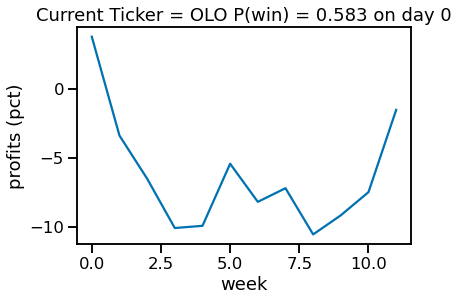

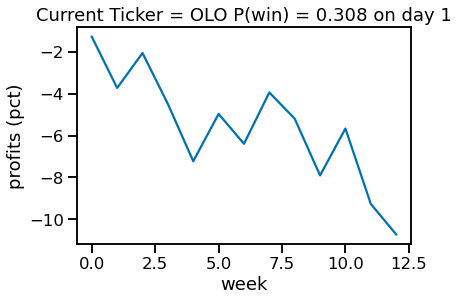

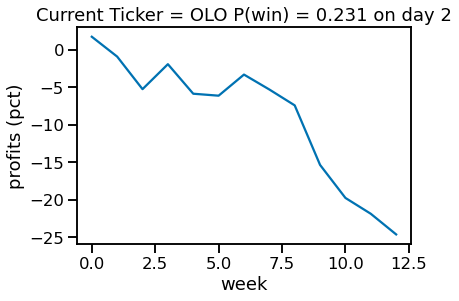

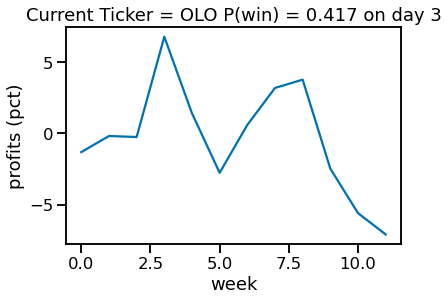

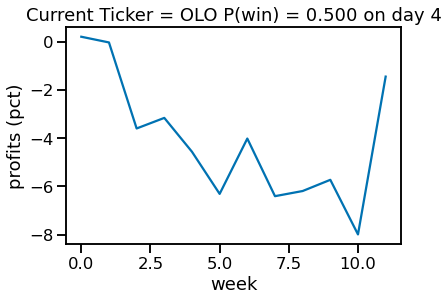

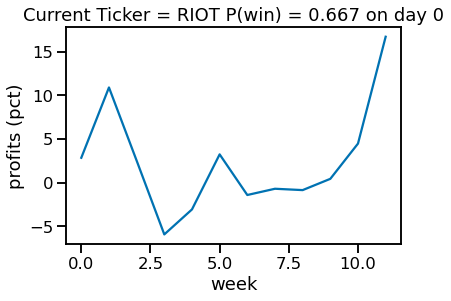

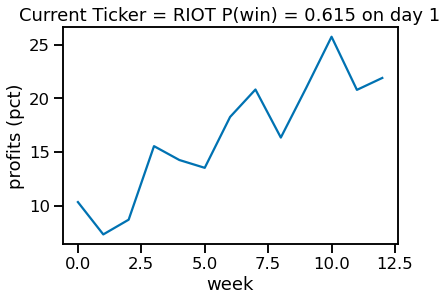

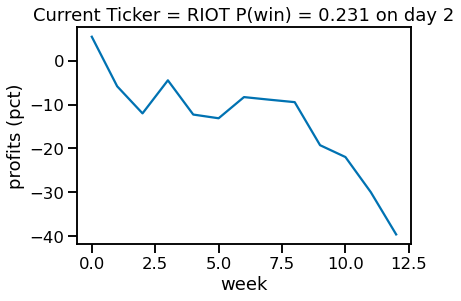

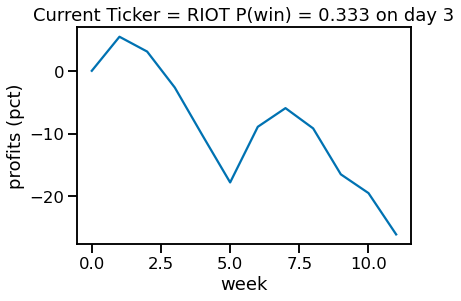

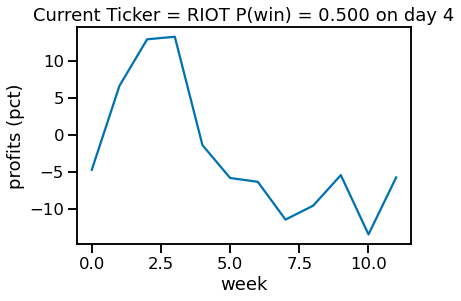

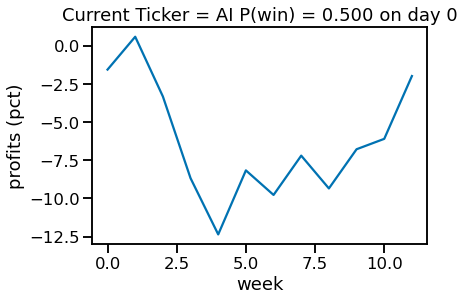

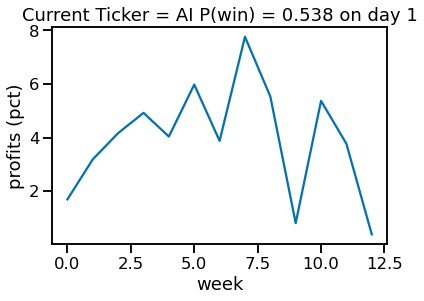

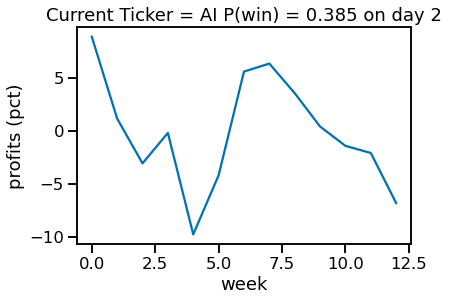

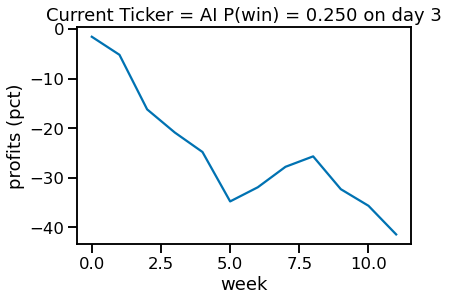

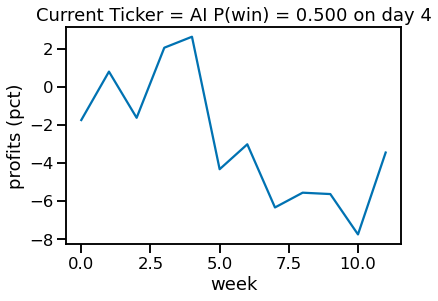

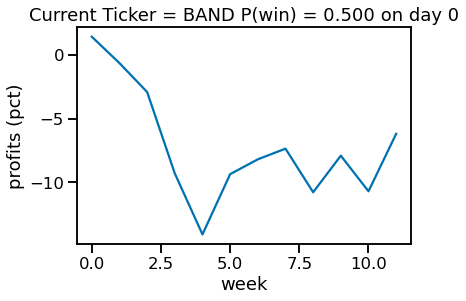

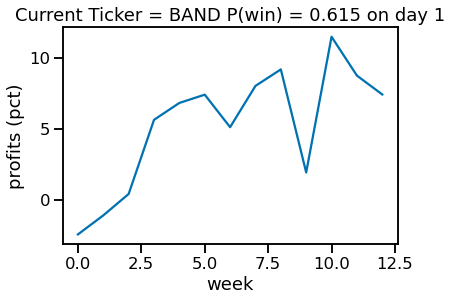

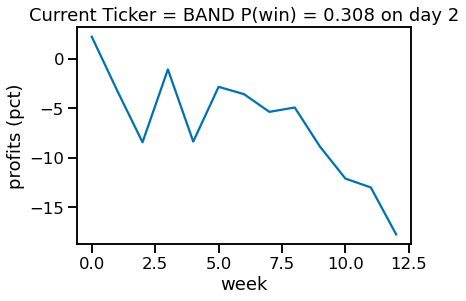

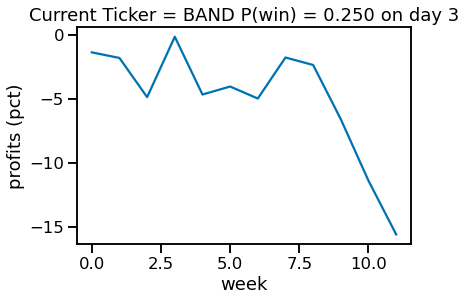

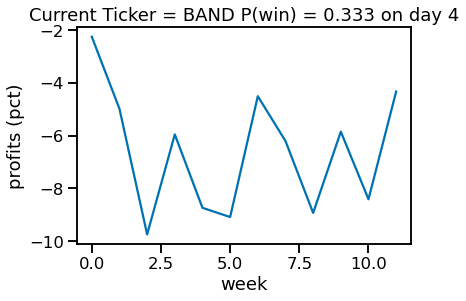

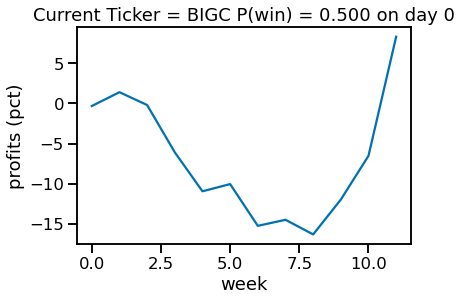

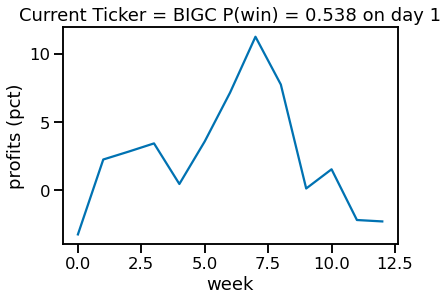

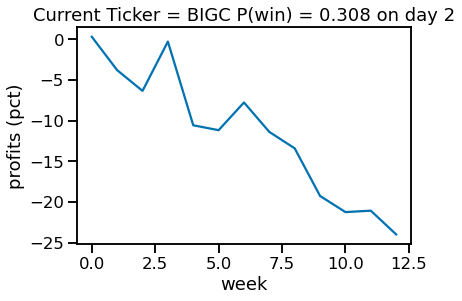

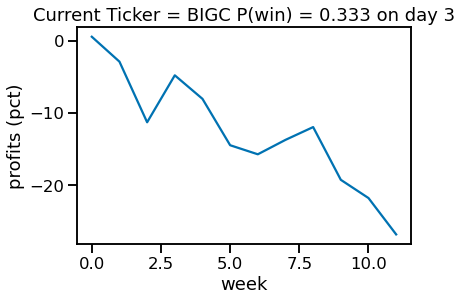

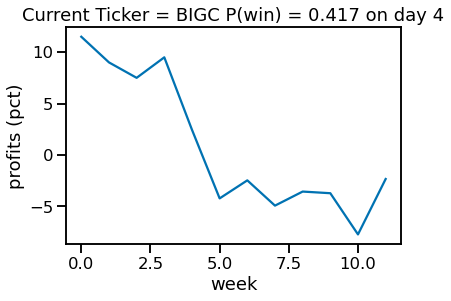

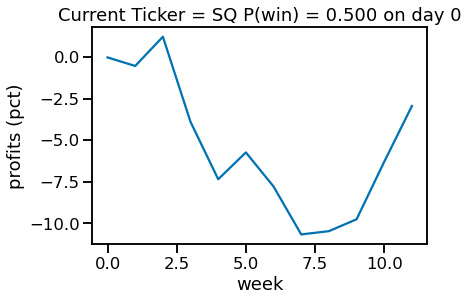

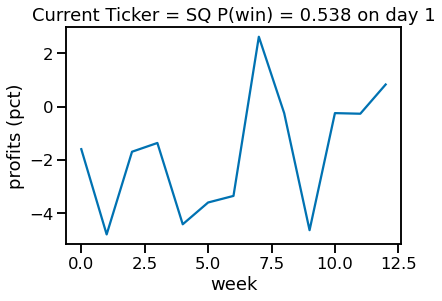

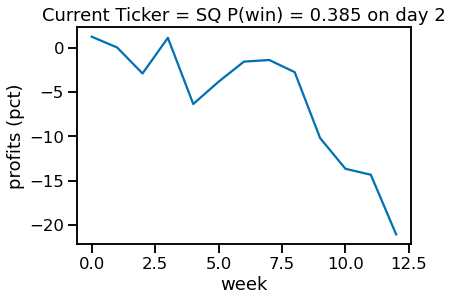

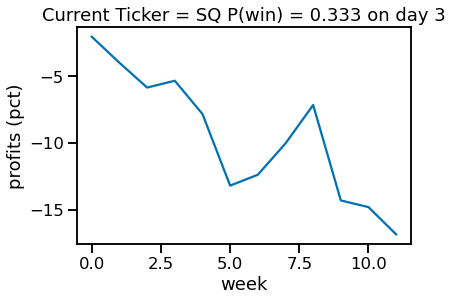

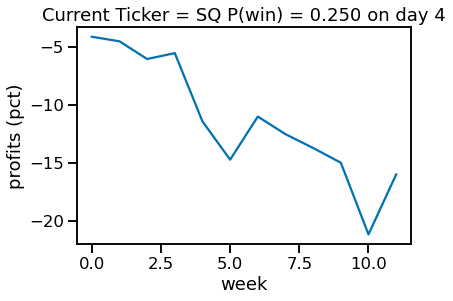

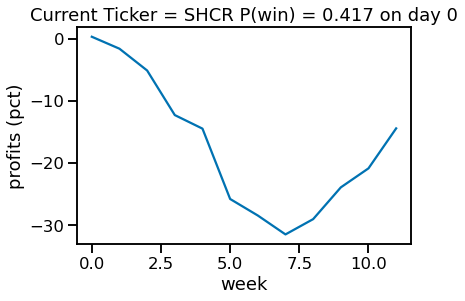

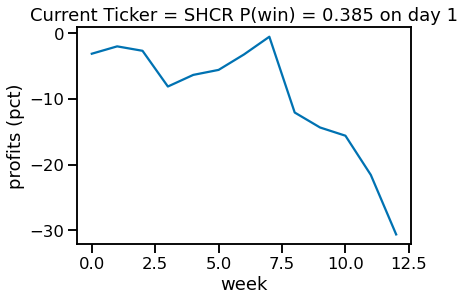

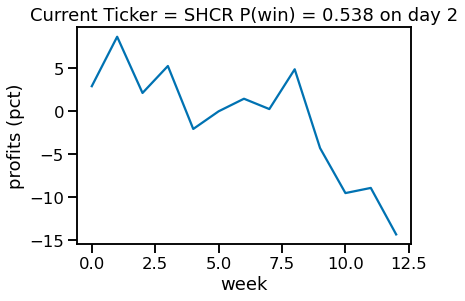

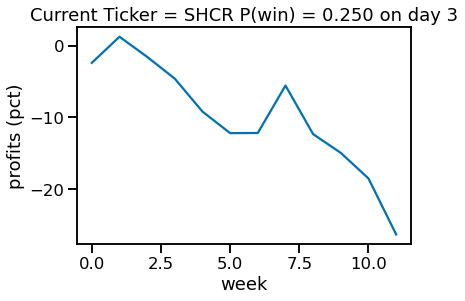

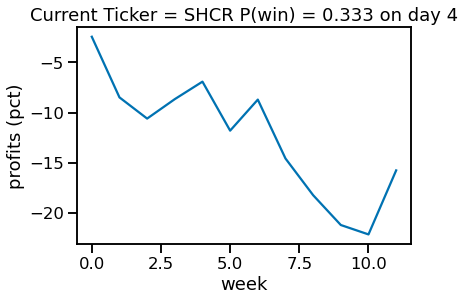

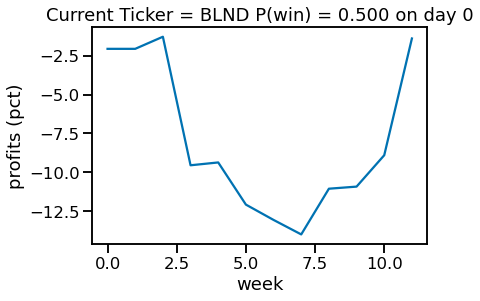

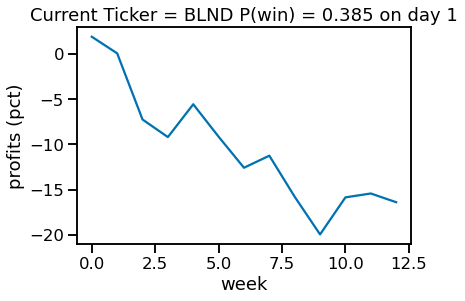

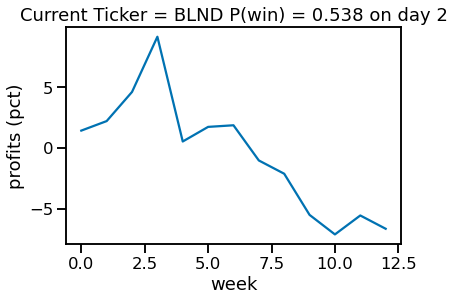

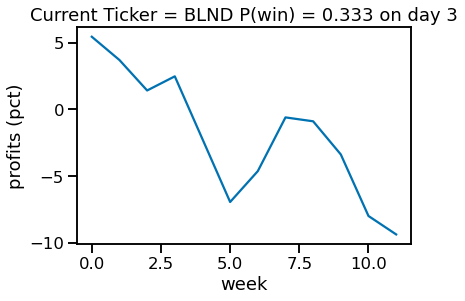

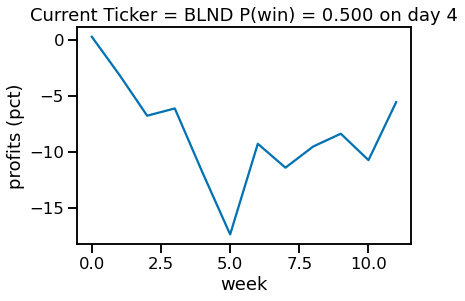

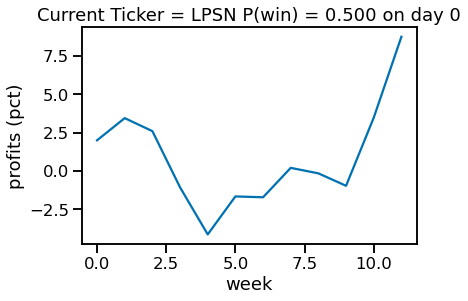

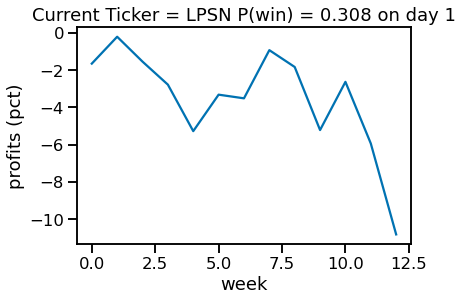

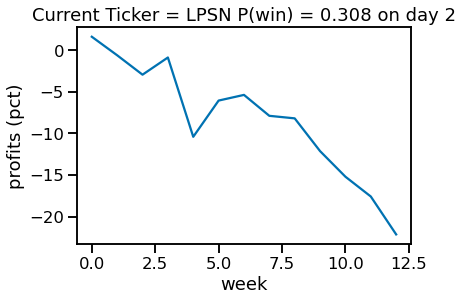

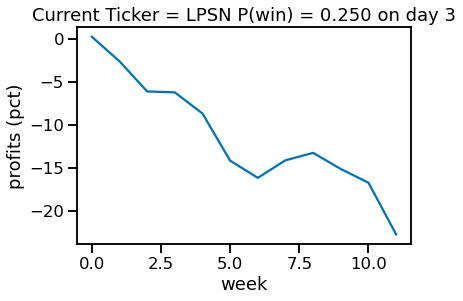

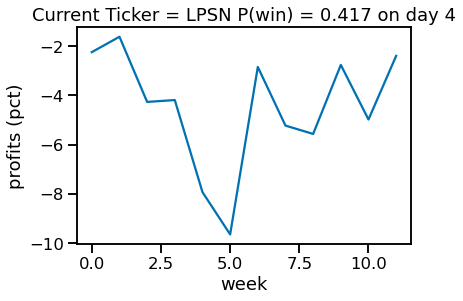

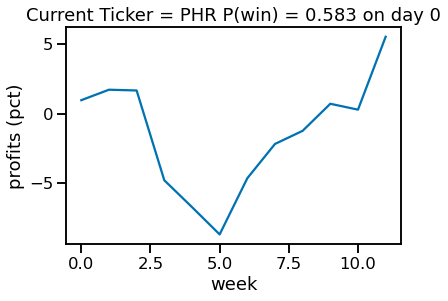

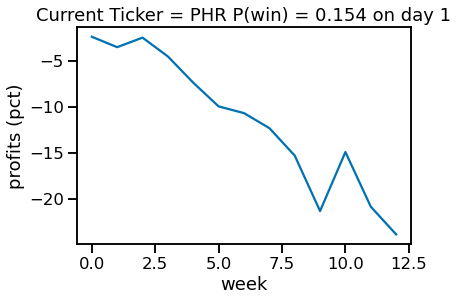

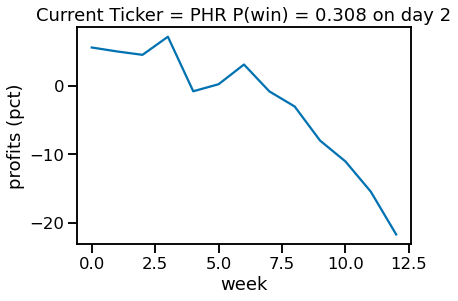

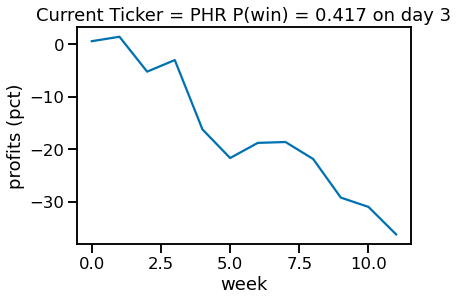

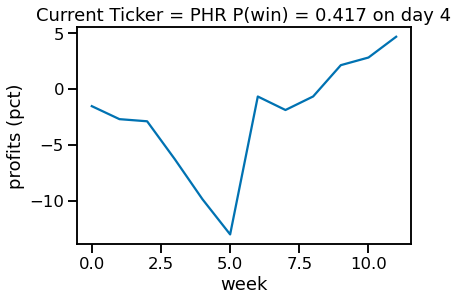

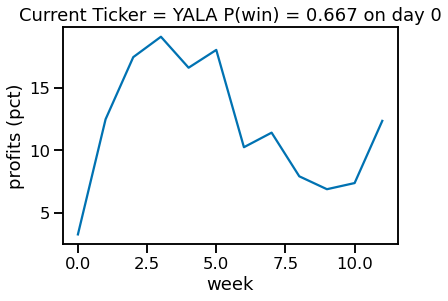

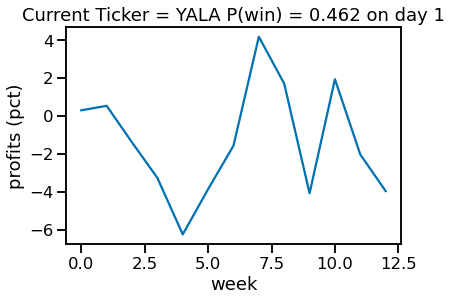

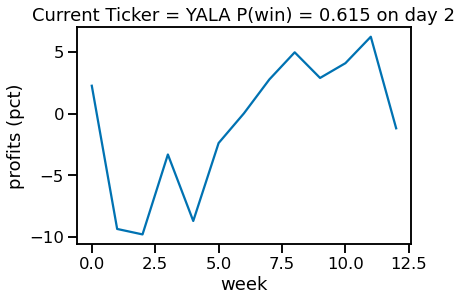

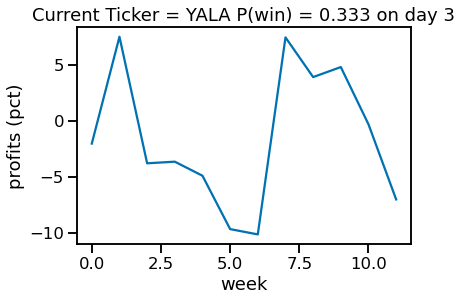

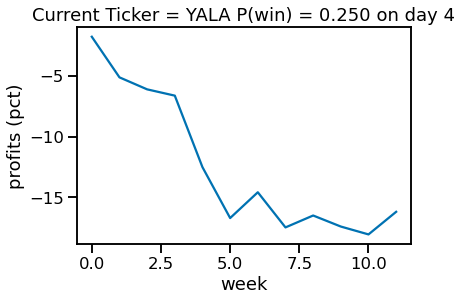

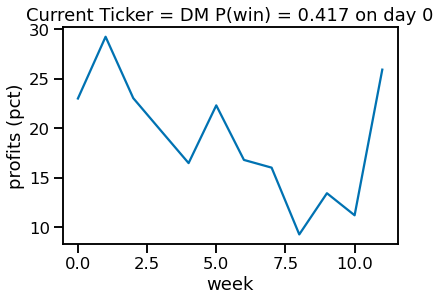

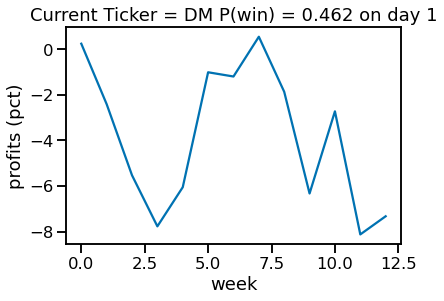

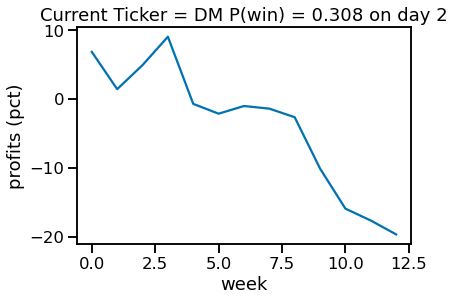

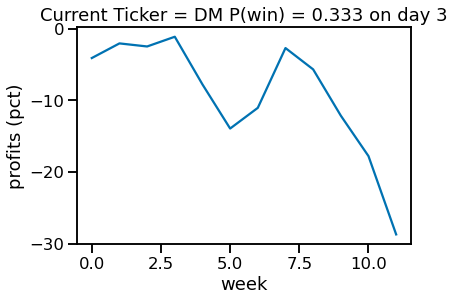

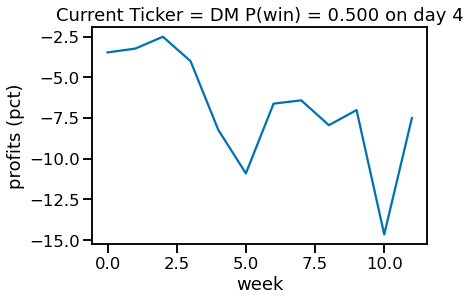

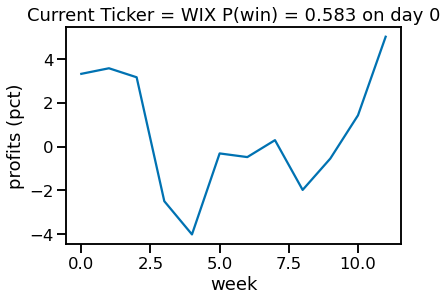

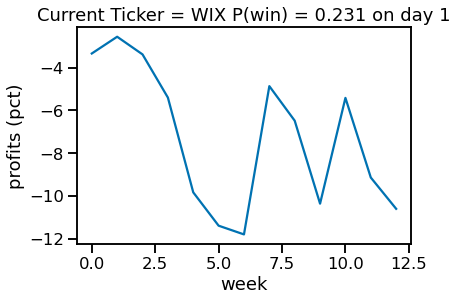

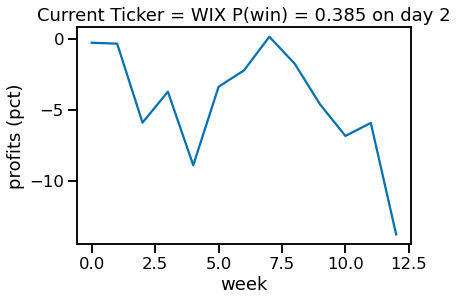

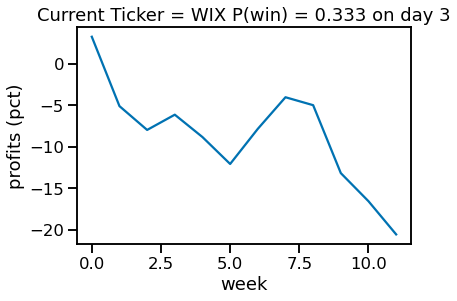

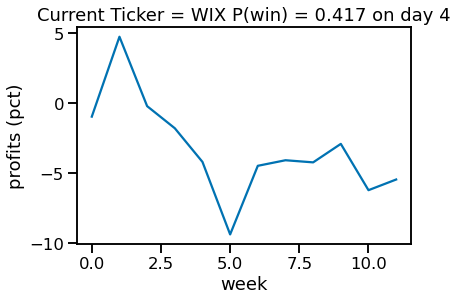

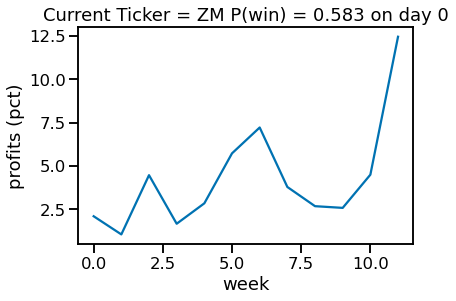

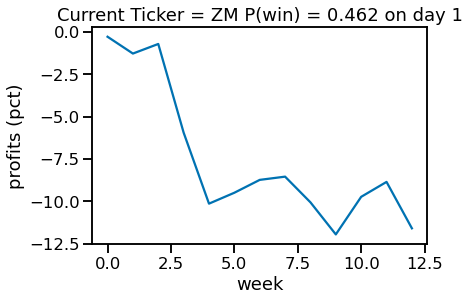

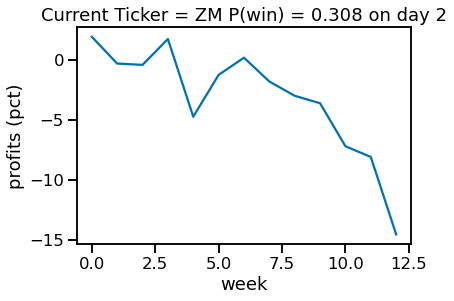

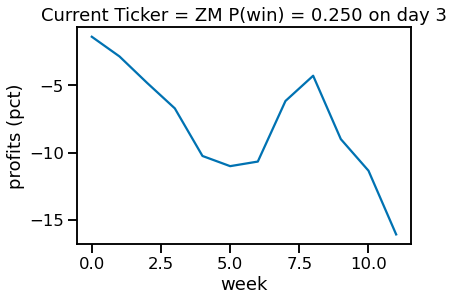

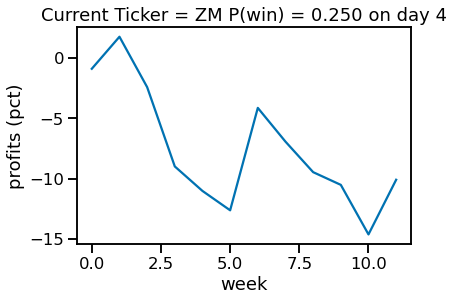

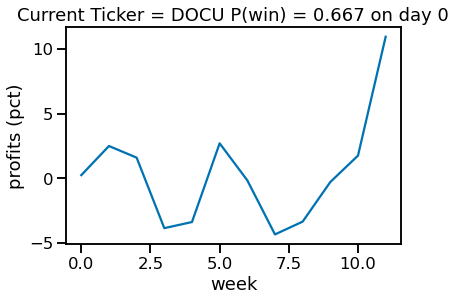

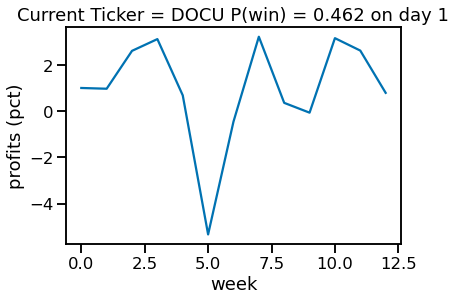

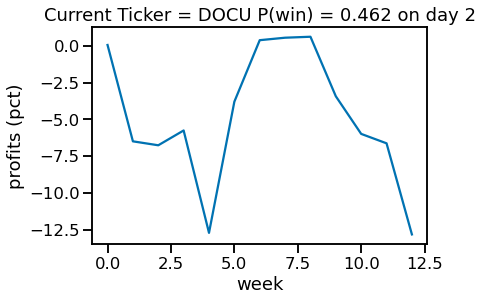

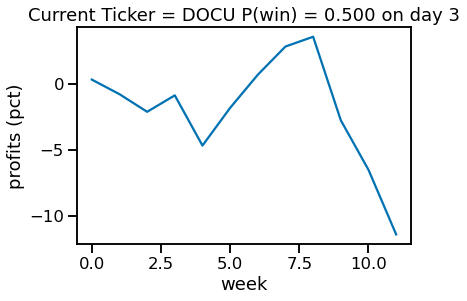

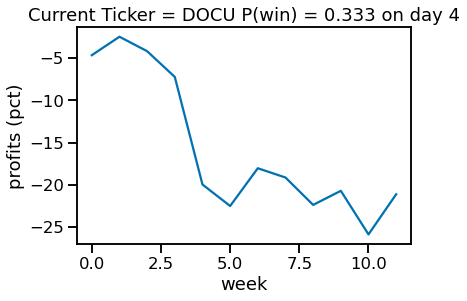

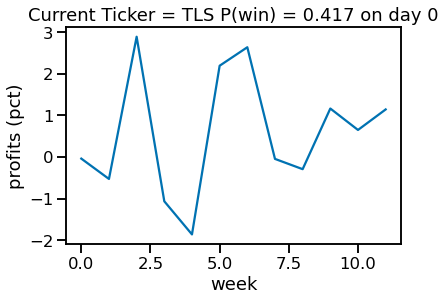

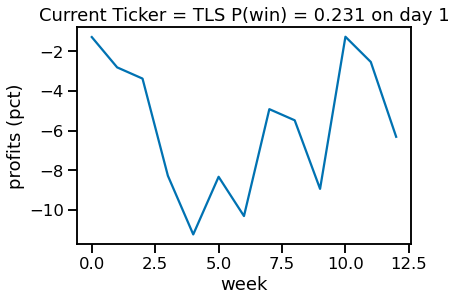

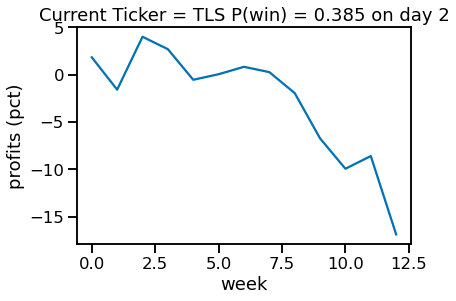

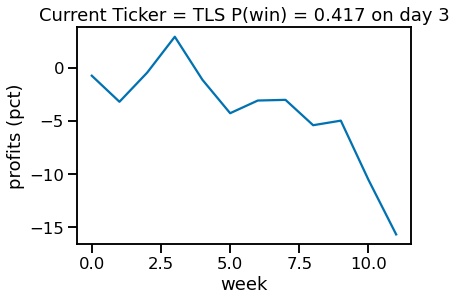

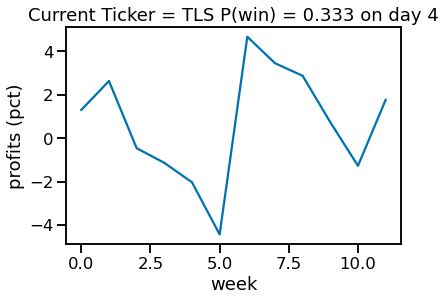

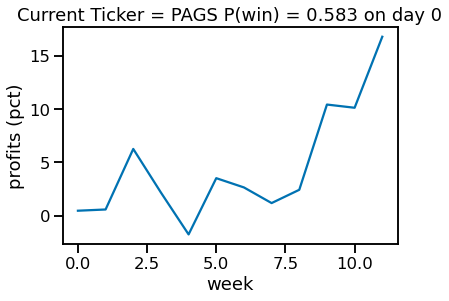

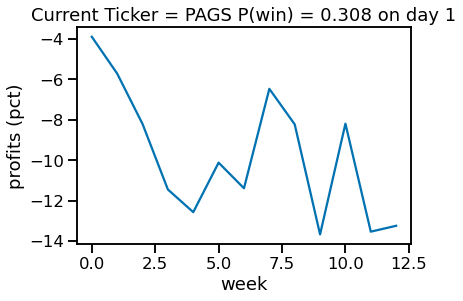

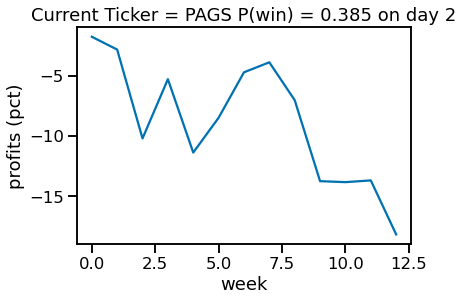

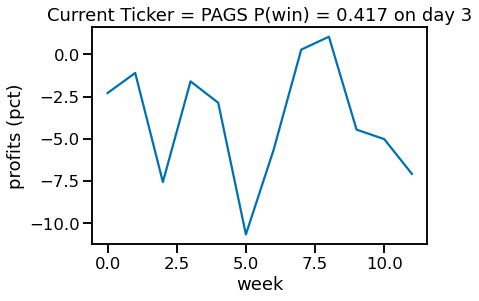

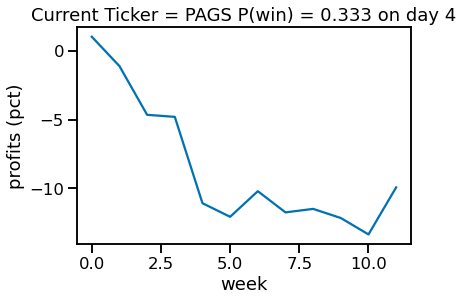

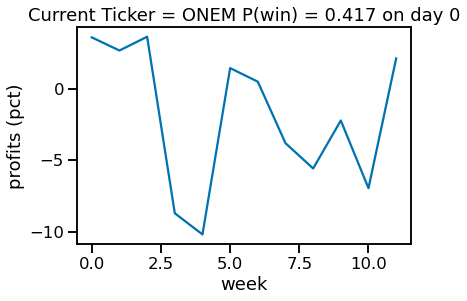

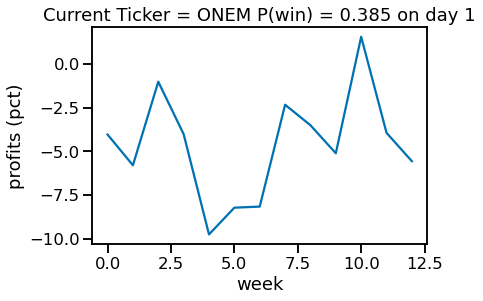

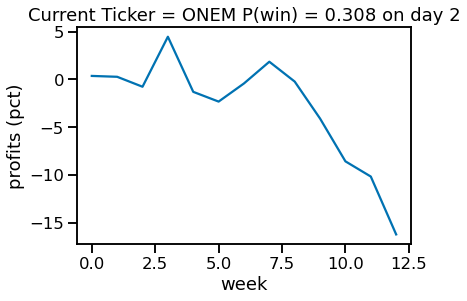

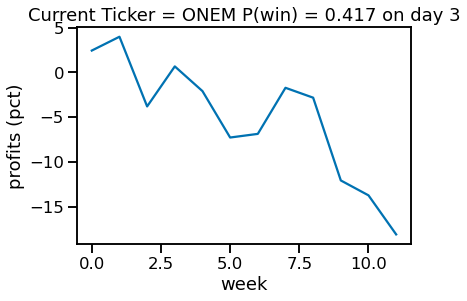

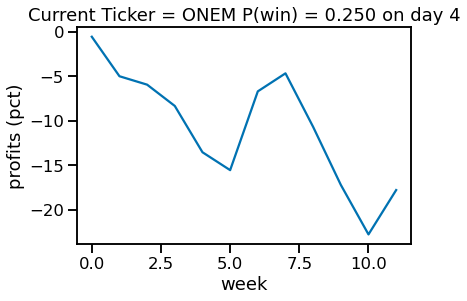

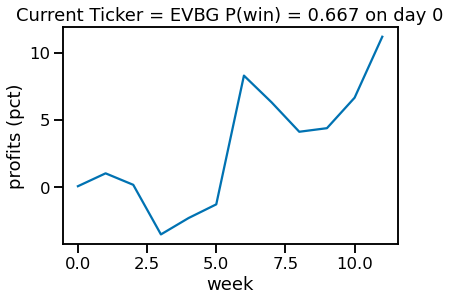

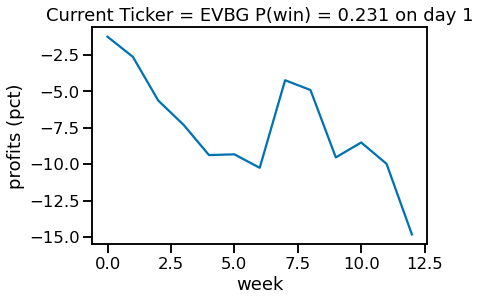

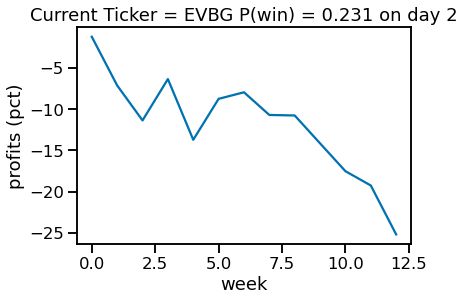

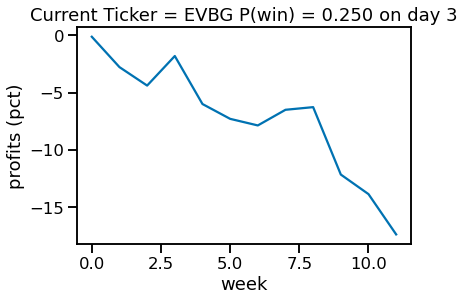

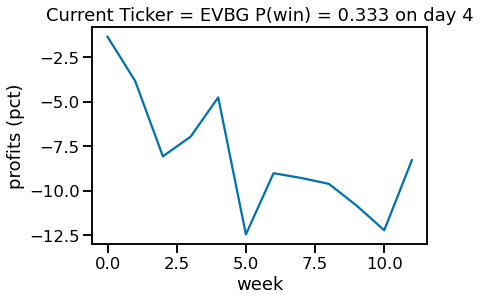

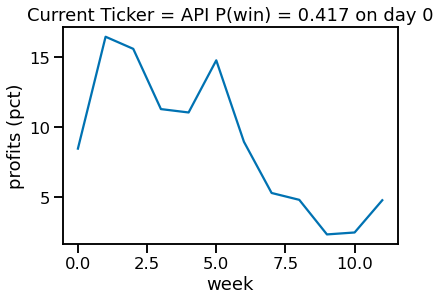

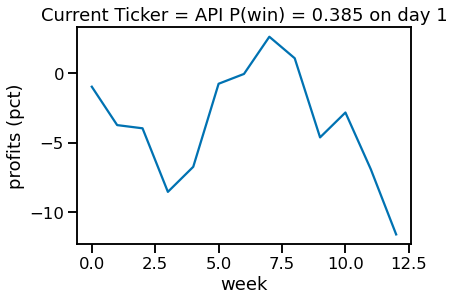

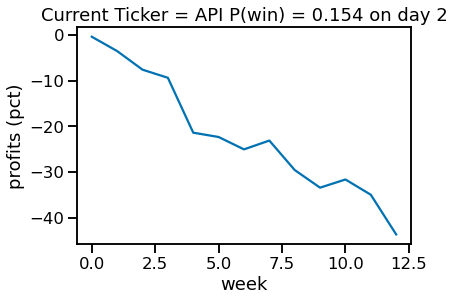

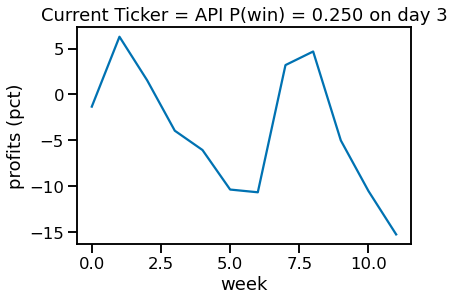

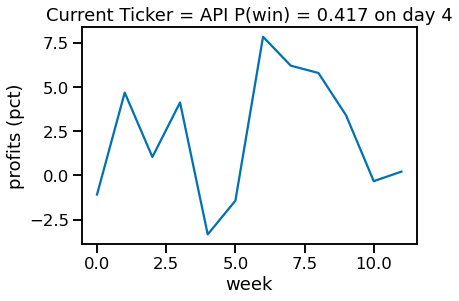

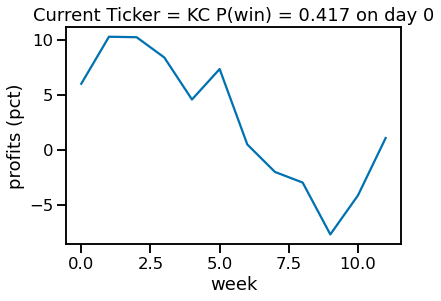

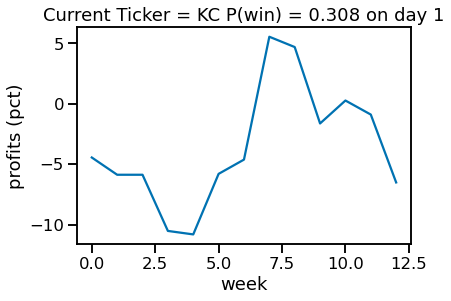

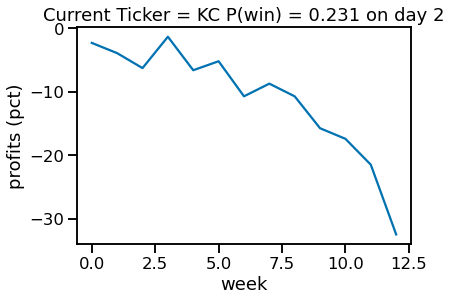

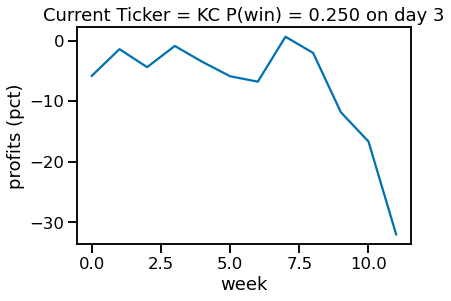

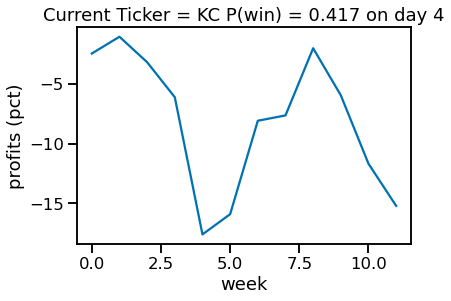

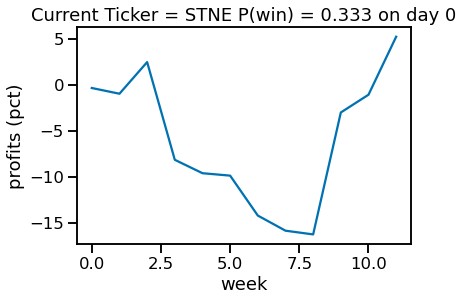

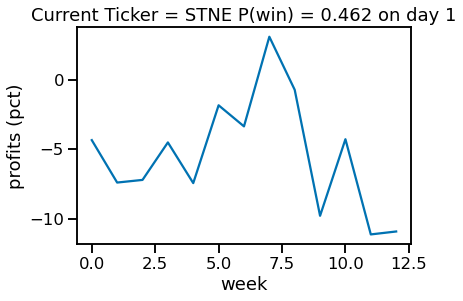

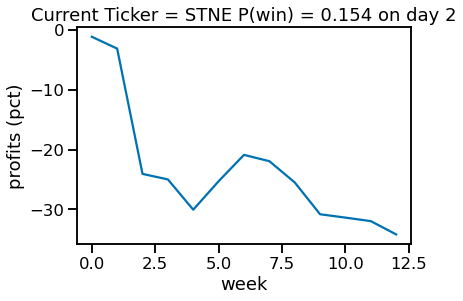

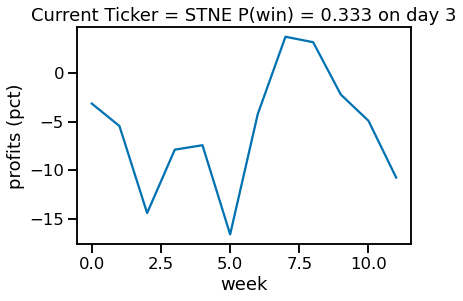

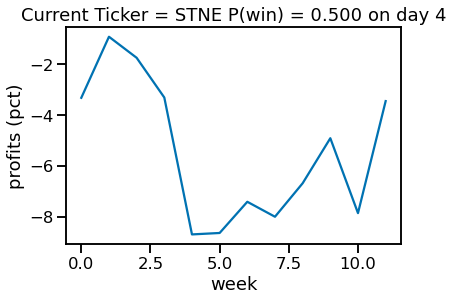

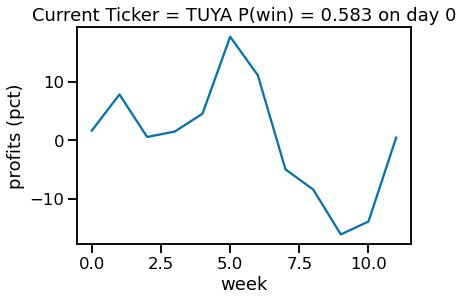

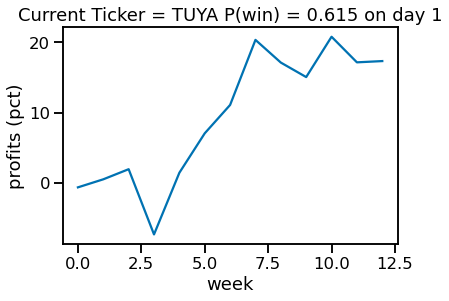

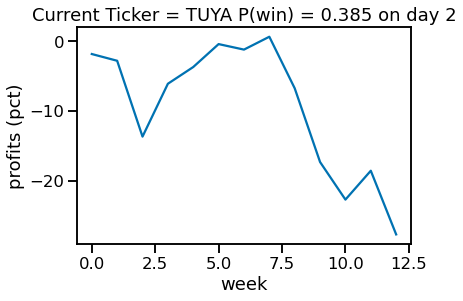

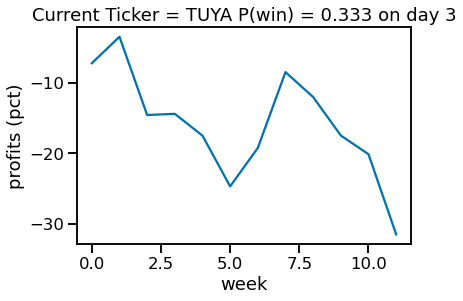

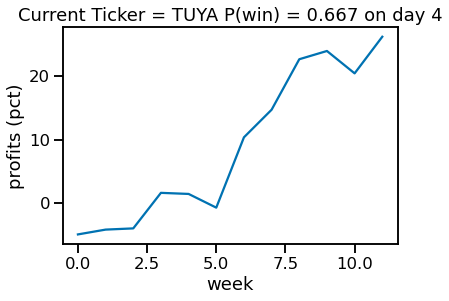

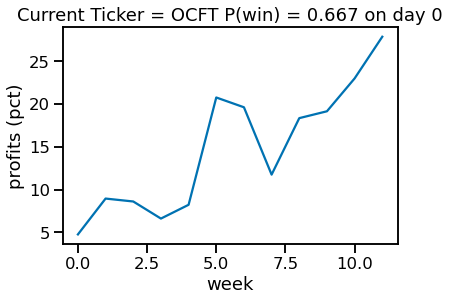

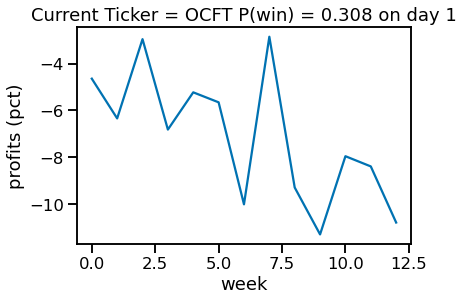

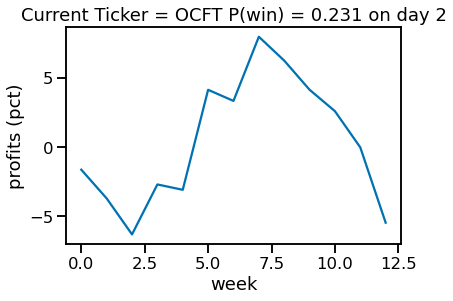

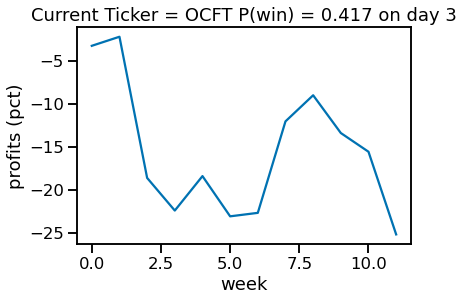

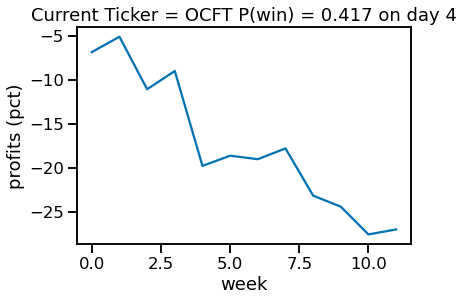

In [7]:
import plotly.express as px

backtest_data = dict()
for ticker, data in historical_data.items():
    # print(f'Current Ticker: {ticker}')
    for i in range(0,5):
        profits = backtest_in_percent(data, day= i)
        backtest_data[f'{ticker}_day_{i}'] = profits
        plot_profits_pct(ticker, profits, day = i) 

In [8]:
backtest_data_mon = dict()
backtest_data_tue = dict()
backtest_data_wed = dict()
backtest_data_thu = dict()
backtest_data_fri = dict()

for ticker, data in historical_data.items():
    backtest_data_mon[ticker] = backtest_in_dollars(data, 0)
    backtest_data_tue[ticker] = backtest_in_dollars(data, 1)
    backtest_data_wed[ticker] = backtest_in_dollars(data, 2)
    backtest_data_thu[ticker] = backtest_in_dollars(data, 3)
    backtest_data_fri[ticker] = backtest_in_dollars(data, 4)

In [9]:
# Lets start by analyzing mondays
import statistics as st
# df_mon = pd.DataFrame(backtest_data_mon)

def verify_data_length(dictionary, req_len):
    bad = []
    for k,v in dictionary.items():
        if len(v) < req_len:
            bad.append(k)
    for b in bad:
        dictionary.pop(b)

    return dictionary

In [10]:
backtest_data_mon = verify_data_length(backtest_data_mon, 12)
backtest_data_tue = verify_data_length(backtest_data_tue, 12)
backtest_data_wed= verify_data_length(backtest_data_wed, 12)
backtest_data_thu = verify_data_length(backtest_data_thu, 12)
backtest_data_fri = verify_data_length(backtest_data_fri, 11)

In [11]:
backtest_data_fri

{'BASE': [-1.8448584131792654,
  -4.185900597884226,
  -10.494730559398462,
  0.2680630394850728,
  -7.184832596293734,
  -4.698901629139937,
  1.4306754343068078,
  0.8014606033060987,
  5.774738441440453,
  0.7583472307157916,
  0.0,
  6.160504223954932],
 'SPT': [-1.7363286499592037,
  2.7182672597636395,
  -3.9494829470158206,
  3.0117537060265933,
  -5.762828084476729,
  -3.29796627216044,
  8.15078701737028,
  -2.4103578201417055,
  1.8269714506109944,
  2.1750249691705847,
  0.050377663981131804,
  9.126705794344328],
 'ASAN': [-2.586136658488875,
  6.008522892370825,
  -0.8671510045733543,
  2.1933714669611937,
  -5.518540273038209,
  -8.971375776890621,
  11.919671470021795,
  -1.9494514900672515,
  -0.8602623527480519,
  -2.132790006441915,
  -3.35103335687725,
  3.1955665902125507],
 'XM': [2.766607102426739,
  -2.6712566341485395,
  -1.0216599382039782,
  1.333629551862675,
  -0.367016555429369,
  -0.7395055028771746,
  6.512052082491892,
  -1.0945105121029042,
  -1.7207231

In [12]:
TAX_RATE = 0.35

In [13]:
df_mon = pd.DataFrame(backtest_data_mon)
# df_mon.head()
mon_agg_stats = dict()
for x in df_mon.columns:
   mon_agg_stats[x] = ["min", "max", "median", "mean", "std"]

mon_stats_df = df_mon.agg(mon_agg_stats)
# mon_stats_df.head()

mon_sharpes = dict()
for tick in mon_stats_df.columns:
    mon_sharpes[tick] = mon_stats_df[tick]['mean']*TAX_RATE / mon_stats_df[tick]['std']
mon_stats_df = mon_stats_df.append(mon_sharpes, ignore_index=True)
mon_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

mon_stats_df = mon_stats_df.transpose()
mon_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)

min        max    median      mean       std    sharpe
COUP  -3.077145   9.623747  1.916366  2.320063  4.152383  0.195556
HCAT  -2.380071   4.507752  1.192816  0.899011  1.977633  0.159106
OCFT  -9.501716  13.604554  3.057116  2.495304  5.757527  0.151689
TWLO  -1.695934   6.846762  0.801013  0.964219  2.435526  0.138564
DCT   -4.449814   7.783265  1.000839  1.308837  3.445415  0.132957
...         ...        ...       ...       ...       ...       ...
BAND  -6.204036   4.093525 -0.665353 -0.559283  3.345262 -0.058515
NLST -10.308917   8.199471 -0.637338 -0.847093  4.181838 -0.070898
EVCM  -4.152612   4.188800 -0.530994 -0.673620  2.412286 -0.097736
SHCR  -9.760776   5.150792 -1.927168 -1.229535  4.283970 -0.100453
CLBT  -4.348384   1.670863 -0.626199 -1.198465  1.905696 -0.220110

[71 rows x 6 columns]

In [14]:
df_tue = pd.DataFrame(backtest_data_tue)
# df_tue.head()

tue_agg_stats = dict()
for x in df_tue.columns:
   tue_agg_stats[x] = ["min", "max", "median", "mean", "std"]

tue_stats_df = df_tue.agg(tue_agg_stats)
# tue_stats_df.head()

tue_sharpes = dict()
for tick in tue_stats_df.columns:
   tue_sharpes[tick] = tue_stats_df[tick]['mean']*TAX_RATE / tue_stats_df[tick]['std']
tue_stats_df = tue_stats_df.append(tue_sharpes, ignore_index=True)
tue_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

tue_stats_df = tue_stats_df.transpose()
tue_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)
tue_stats_df

min        max    median      mean       std    sharpe
BASE -10.723380   9.232431 -0.683720  0.052211  5.749687  0.003178
SPT   -8.504246   5.917830 -0.789922 -0.118536  4.939918 -0.008398
ASAN -10.815287   7.194015 -1.516988 -0.539673  5.262152 -0.035895
XM    -8.151156   2.509182 -1.574844 -1.482970  2.979391 -0.174210
RPAY  -8.018871   4.203365 -0.106038 -0.349950  3.402979 -0.035993
...         ...        ...       ...       ...       ...       ...
API   -5.730435   5.573693 -0.959447 -0.893757  3.308775 -0.094541
KC    -6.565463   9.664786 -0.892884 -0.573545  4.380335 -0.045828
STNE  -8.931130   6.205713 -1.481771 -0.897971  4.654967 -0.067517
TUYA  -9.456147  10.229914  1.136883  1.296474  5.594130  0.081115
OCFT  -6.206570   6.439316 -1.616202 -0.850009  3.591504 -0.082835

[71 rows x 6 columns]

In [15]:
df_wed = pd.DataFrame(backtest_data_wed)
# df_tue.head()

wed_agg_stats = dict()
for x in df_wed.columns:
   wed_agg_stats[x] = ["min", "max", "median", "mean", "std"]

wed_stats_df = df_wed.agg(wed_agg_stats)
# tue_stats_df.head()

wed_sharpes = dict()
for tick in wed_stats_df.columns:
   wed_sharpes[tick] = wed_stats_df[tick]['mean']*TAX_RATE / wed_stats_df[tick]['std']
wed_stats_df = wed_stats_df.append(wed_sharpes, ignore_index=True)
wed_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

wed_stats_df = wed_stats_df.transpose()
wed_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)
wed_stats_df

min       max    median      mean       std    sharpe
BASE -16.500623  8.872571  0.320972 -1.302746  6.614794 -0.068930
SPT  -15.408559  4.728621 -2.481377 -2.554998  5.317922 -0.168158
ASAN -13.748344  7.549305 -3.023786 -1.733590  6.532029 -0.092889
XM    -4.370609  1.460623 -2.134225 -1.756327  1.835946 -0.334822
RPAY  -3.407250  5.578625 -0.636824 -0.437355  2.562322 -0.059740
...         ...       ...       ...       ...       ...       ...
API  -10.931264  1.486340 -2.401987 -2.807783  3.293294 -0.298402
KC    -8.805754  4.642873 -2.265588 -2.212362  3.474151 -0.222882
STNE -20.315270  3.430713 -1.119405 -2.398926  5.833481 -0.143932
TUYA -10.583470  6.573140 -0.950278 -2.010646  5.482366 -0.128362
OCFT  -5.413673  7.005326 -1.623375 -0.461459  3.441258 -0.046934

[71 rows x 6 columns]

In [16]:
df_thu = pd.DataFrame(backtest_data_thu)
# df_tue.head()

thu_agg_stats = dict()
for x in df_thu.columns:
   thu_agg_stats[x] = ["min", "max", "median", "mean", "std"]

thu_stats_df = df_thu.agg(thu_agg_stats)
# tue_stats_df.head()

thu_sharpes = dict()
for tick in thu_stats_df.columns:
   thu_sharpes[tick] = thu_stats_df[tick]['mean']*TAX_RATE / thu_stats_df[tick]['std']
thu_stats_df = thu_stats_df.append(thu_sharpes, ignore_index=True)
thu_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

thu_stats_df = thu_stats_df.transpose()
thu_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)
thu_stats_df

min        max    median      mean       std    sharpe
BASE  -8.873751   4.908334 -1.993569 -2.104519  4.504274 -0.163529
SPT  -14.854840   9.505840 -0.945659 -2.188180  6.605909 -0.115936
ASAN  -9.147883   5.043953 -1.228993 -1.300112  4.723191 -0.096341
XM    -4.532532   4.477914 -0.580579 -1.086357  2.674736 -0.142154
RPAY  -2.801075   6.417406 -1.241976 -0.012006  2.650590 -0.001585
...         ...        ...       ...       ...       ...       ...
API   -9.983212  12.362012 -3.017718 -1.342775  6.114805 -0.076858
KC   -12.799363   6.897548 -2.638619 -2.442285  5.550511 -0.154004
STNE  -8.466177  10.377012 -2.408423 -1.037836  6.078649 -0.059757
TUYA -10.652975   8.719153 -2.910269 -2.428605  5.745836 -0.147935
OCFT -16.017501   8.311611 -2.474870 -2.047284  6.112556 -0.117226

[71 rows x 6 columns]

In [17]:
df_fri = pd.DataFrame(backtest_data_fri)
fri_agg_stats = dict()
for x in df_fri.columns:
   fri_agg_stats[x] = ["min", "max", "median", "mean", "std"]

fri_stats_df = df_fri.agg(fri_agg_stats)
# tue_stats_df.head()

fri_sharpes = dict()
for tick in fri_stats_df.columns:
   fri_sharpes[tick] = fri_stats_df[tick]['mean']*TAX_RATE / fri_stats_df[tick]['std']
fri_stats_df = fri_stats_df.append(fri_sharpes, ignore_index=True)
# fri_stats_df
fri_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

fri_stats_df = fri_stats_df.transpose()
fri_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)
fri_stats_df

min        max    median      mean       std    sharpe
BASE -10.494731   6.160504  0.134032 -1.101286  4.906838 -0.078554
SPT   -5.762828   9.126706  0.938675  0.825244  4.618149  0.062544
ASAN  -8.971376  11.919671 -1.408301 -0.243301  5.487106 -0.015519
XM    -4.852524   6.512052 -0.880583 -0.010892  3.102679 -0.001229
RPAY  -4.237978   4.160849 -1.064286 -0.709544  2.422428 -0.102517
...         ...        ...       ...       ...       ...       ...
API   -7.770439   9.107226 -0.757893 -0.074748  4.564818 -0.005731
KC   -10.813070   6.627321 -2.274249 -1.289405  4.697093 -0.096079
STNE  -5.216421   4.068692 -0.247158 -0.316258  2.622485 -0.042208
TUYA  -4.918028  10.943184  1.163592  2.331167  5.126408  0.159158
OCFT  -9.823312   1.848710 -0.657049 -2.057734  3.810618 -0.189000

[71 rows x 6 columns]